# 0: Importing packages

In [192]:
import numpy as np
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
import scipy.stats as si
import sympy as sy
import math as math
import math
import cmath as cmath
import pandas as pd
import matplotlib.cm as cm
import tensorflow as tf
from tensorflow import keras
from sklearn import preprocessing
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from math import sqrt
from mpl_toolkits.mplot3d import Axes3D
from scipy.interpolate import interp1d
from scipy.interpolate import UnivariateSpline
from scipy.interpolate import CubicSpline
from sympy.stats import Normal, cdf
from sympy import init_printing
init_printing()
from scipy.stats import norm
import torch
import torch.nn as nn
import torch.nn.functional as F

In [126]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# 1: 1-Dimensional cases

### 1-D Cubic Splinee interpolation for Cos function (simple exammple)

https://pythonnumericalmethods.berkeley.edu/notebooks/chapter17.03-Cubic-Spline-Interpolation.html


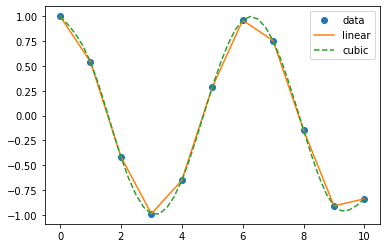

In [193]:
x = np.linspace(0, 10, num=11, endpoint=True)
y = np.cos(x)
f = interp1d(x, y)
#f2 = interp1d(x, y, kind='cubic')
f2 = CubicSpline(x, y, bc_type='natural')

xnew = np.linspace(0, 10, num=41, endpoint=True)

plt.plot(x, y, 'o', xnew, f(xnew), '-', xnew, f2(xnew), '--')
plt.legend(['data', 'linear', 'cubic'], loc='best')
#plt.savefig('/content/drive/MyDrive/Colab Notebooks/Thesis/Graph/Interpolation.eps', format='eps') ## YESSSSSSSSSS
plt.show()

### Fit natural spline to the BS price

Define the BS call price

In [194]:
N = norm.cdf

#S: spot price
#K: strike price
#T: time to maturity
#r: interest rate
#sigma: volatility of underlying asset
    
def BS_CALL(S, K, T, r, sigma):
    d1 = (np.log(S/K) + (r + sigma**2/2)*T) / (sigma*np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    return S * N(d1) - K * np.exp(-r*T)* N(d2)

Initialize the parameters



In [195]:
T = 1; K = 100;sigma = 0.2;r = 0.1

# logS for plotting the exact BS graph
# logS4 for interpolation
logS = np.linspace(-3, 3, num=300, endpoint = True)
logS4 =[-0.75,-0.25,0.25,0.75]

# scale the spot price by K, ////// log spot = log(S/K)  
S=[np.exp(s)*100 for s in logS]
S4 = [np.exp(s)*100 for s in logS4]

call = [BS_CALL(s, K, T, r, sigma) for s in S]
call4 = [BS_CALL(s, K, T, r, sigma) for s in S4]

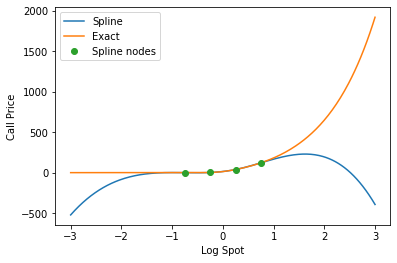

In [196]:
spline = CubicSpline(logS4,call4, bc_type = 'natural')
plt.plot(logS,spline(logS))
plt.plot(logS,call)

# plot the grid points
plt.plot(logS4,call4, 'o')
plt.legend(['Spline', 'Exact','Spline nodes'], loc='best')
plt.xlabel('Log Spot')
plt.ylabel('Call Price') 
#plt.savefig('/content/drive/MyDrive/Colab Notebooks/Thesis/Graph/1D_spline.eps', format='eps') #YESSSSSSSSSS
plt.show()

## Fit spline with asymtotic control to BS

Adding two asymptotic point  $h_{0}$,  $h_{N+1}$

stock price in BS follows log normal distribution, if we take -2,2 as two asymptotic points, we could cover 97.7% of possible stock price. 

And we know that when stock price becomes very large,like log(S/100)>2, the BS call price tends to be S-K; when stock price is small, like the log spot---log(S/100) small than -2, the BS call price tends to be 0.

Add two more points in our set of spline nodes. One point is between $h_{0}$ and $h_{1}$, we call $h_{\frac{1}{2}}$ here. Another point is between $h_{N}$ and $h_{N+1}$, we call $h_{N+\frac{1}{2}}$ here.

According to the authors' experiments in the paper "Neural network with asymptotics control", these extra points can be placed in the middle of the corresponding intervals.

In [197]:
logS6 =[-2,-0.75,-0.25,0.25,0.75,2] # adding two asymptotic points
logS8 =[-2,-1.375,-0.75,-0.25,0.25,0.75,1.375,2] # adding two more points to control the second derivatives at the end point

# scale the spot price by 100, ////// log spot = log(S/100)  scale 1/100 first， then take log
S6 = [np.exp(s)*100 for s in logS6]
S8 = [np.exp(s)*100 for s in logS8]


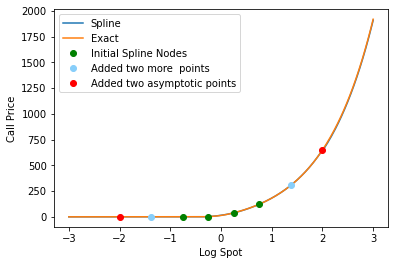

In [198]:
"""
adding h_0, h_(1/2),h_(N+1/2), h_(N+1)
"""

call8 = [BS_CALL(s, K, T, r, sigma) for s in S8]
call6 = [BS_CALL(s, K, T, r, sigma) for s in S6]
spline8 = CubicSpline(logS8,call8,bc_type = ((1, 0), (1, S8[-1])),extrapolate= True)

def new_spline(logS,h_left,h_right):
  new_spline = []
  for i in logS:
      if i <= h_left:
        C = 0
      if h_left < i < h_right:
        C = spline8(i)
      if i >= h_right:
        C = np.exp(i)*100-K
      new_spline.append(C)
  new_spline = np.array(new_spline)
  return new_spline
 
plt.plot(logS,new_spline(logS,logS8[0],logS8[-1]))
plt.plot(logS,call)
plt.plot(logS8[2:6],call8[2:6], 'o', color = 'green')
plt.plot([logS8[1],logS8[6]],[call8[1],call8[6]], 'o', color = 'lightskyblue')
plt.plot([logS8[0],logS8[-1]],[call8[0],call8[-1]], 'ro')
plt.legend(['Spline', 'Exact','Initial Spline Nodes','Added two more  points','Added two asymptotic points'], loc='best')
plt.xlabel('Log Spot')
plt.ylabel('Call Price')
#plt.savefig('/content/drive/MyDrive/Colab Notebooks/Thesis/Graph/1D_spline_controlled.eps', format='eps') #YESSSSSSSSSS
plt.show()

Demonstrates the improvements in the fit to the Black-Scholes func- tion when we control the asymptotics and second derivatives at the end points.

#2: 2-Dimensional Cases

2-1: Blue surface: 2D asymptotic spline approximation;
red dots: corners of the asymptotic region; 
dark blue dots: spline nodes (a 4 × 4 grid).

### (1) Get the data prepared

In [199]:
# initial stock price S, S8 has been defined before  sigma_ref = 20%

logvol = np.linspace(-3, 3, 300, endpoint = True) 
vol_ref = 0.2
# rescale the range , the 0 < vol <1
vol=[np.exp(v)*vol_ref for v in logvol]

logvol4 =[-0.75,-0.25,0.25,0.75]
vol4=[np.exp(v)*vol_ref for v in logvol4]

logvol6 =[-2,-0.75,-0.25,0.25,0.75,2]
vol6=[np.exp(v)*vol_ref for v in logvol6]

logvol8 =[-2,-1.375,-0.75,-0.25,0.25,0.75,1.375,2]
vol8=[np.exp(v)*vol_ref for v in logvol8]

"""
Get the exact call prices for different stock prices and volatility 100X100 prices
"""

call_2d = np.array([]) 
for i in range(0, len(vol)):
  for j in range(0, len(S)):
    call_2d = np.append(call_2d,BS_CALL(S[j], K, T, r, vol[i])) # K = 100, T = 1, r = 0.05
    
call_2d = call_2d.reshape(len(S), len(vol)) # A matrix with S-stock price in x-axix, vol in y-axix 

"""
Get the 2D call prices 4x4 nodes
"""
call4_2d = np.array([])
for i in range(0, len(vol4)):
  for j in range(0, len(S4)):
    call4_2d = np.append(call4_2d,BS_CALL(S4[j], K, T, r, vol4[i]))

call4_2d = call4_2d.reshape(len(S4), len(vol4))

"""
Get the 2D call prices 6x6 nodes
"""
call6_2d = np.array([])
for i in range(0, len(vol6)):
  for j in range(0, len(S6)):
    call6_2d = np.append(call6_2d,BS_CALL(S6[j], K, T, r, vol6[i]))

call6_2d = call6_2d.reshape(len(S6), len(vol6))

"""
Get the 2D call prices 8x8 nodes
"""
call8_2d = np.array([])
for i in range(0, len(vol8)):
  for j in range(0, len(S8)):
    call8_2d = np.append(call8_2d,BS_CALL(S8[j], K, T, r, vol8[i]))

call8_2d = call8_2d.reshape(len(S8), len(vol8))



### (2): 3D surface: 2D asymptotic spline

#### 2-2-1 Define other functions needed


In [200]:

def d1(S, K, r, sigma, T):
    return (np.log(S/K) + (r+sigma*sigma/2)*T)/(sigma*np.sqrt(T))

def d2(S, K, r, sigma, T):
    return d1(S, K, r, sigma, T) - sigma*np.sqrt(T)

def Delta(S, K, r, sigma, T):
    return si.norm.cdf(d1(S, K, r, sigma, T))

def Vega(S, K, r, sigma, T):
    return S*si.norm.pdf(d1(S, K, r, sigma, T))*np.sqrt(T)

def New_spline(splinefunc, logS,h_left,h_right, sigma): 
  new_spline = []
  for i in logS:
      if i <= h_left:
        C = BS_CALL(np.exp(i)*K, K, T, r, sigma)
      if h_left < i < h_right:
        C = splinefunc(i)
      if i >= h_right:
        #C = np.exp(i)*100-K*np.exp(-r)
        C = BS_CALL(np.exp(i)*K, K, T, r, sigma)
      new_spline.append(C)
  new_spline = np.array(new_spline)
  return new_spline


def New_spline_sigma(splinefunc, logvol,h_left,h_right,S):
  new_spline = []
  for i in logvol:
      if i <= h_left:
        C = BS_CALL(S, K, T, r, np.exp(i)* vol_ref)
      if h_left < i < h_right:
        C = splinefunc(i)
      if i >= h_right:
        C = BS_CALL(S, K, T, r, np.exp(i)* vol_ref)
      new_spline.append(C)
  new_spline = np.array(new_spline)
  return new_spline
  


#### 2-2-2 Fit the spline with 2d controlled

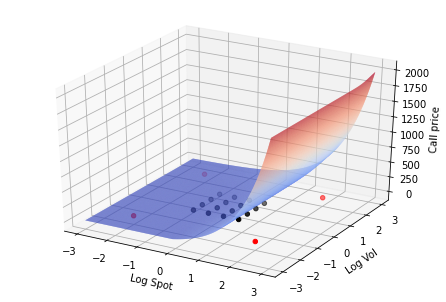

In [135]:
"""
Questions!!!!!!!!!!!!!!!!!!!!!!!!!!
"""
"""
For each log volatility , find the corresponding  1-D spline
"""
sp_vol0 = CubicSpline(logS8,call8_2d[0],bc_type = ((1, Delta(S8[0], K, r, vol8[0], T)*S8[0]), (1, Delta(S8[-1], K, r, vol8[0], T)*S8[-1])),extrapolate= True)
sp_vol1 = CubicSpline(logS8,call8_2d[1],bc_type = ((1, Delta(S8[0], K, r, vol8[1], T)*S8[0]), (1, Delta(S8[-1], K, r, vol8[1], T)*S8[-1])),extrapolate= True)
sp_vol2 = CubicSpline(logS8,call8_2d[2],bc_type = ((1, Delta(S8[0], K, r, vol8[2], T)*S8[0]), (1, Delta(S8[-1], K, r, vol8[2], T)*S8[-1])),extrapolate= True)
sp_vol3 = CubicSpline(logS8,call8_2d[3],bc_type = ((1, Delta(S8[0], K, r, vol8[3], T)*S8[0]), (1, Delta(S8[-1], K, r, vol8[3], T)*S8[-1])),extrapolate= True)
sp_vol4 = CubicSpline(logS8,call8_2d[4],bc_type = ((1, Delta(S8[0], K, r, vol8[4], T)*S8[0]), (1, Delta(S8[-1], K, r, vol8[4], T)*S8[-1])),extrapolate= True)
sp_vol5 = CubicSpline(logS8,call8_2d[5],bc_type = ((1, Delta(S8[0], K, r, vol8[5], T)*S8[0]), (1, Delta(S8[-1], K, r, vol8[5], T)*S8[-1])),extrapolate= True)
sp_vol6 = CubicSpline(logS8,call8_2d[6],bc_type = ((1, Delta(S8[0], K, r, vol8[6], T)*S8[0]), (1, Delta(S8[-1], K, r, vol8[6], T)*S8[-1])),extrapolate= True)
sp_vol7 = CubicSpline(logS8,call8_2d[7],bc_type = ((1, Delta(S8[0], K, r, vol8[7], T)*S8[0]), (1, Delta(S8[-1], K, r, vol8[7], T)*S8[-1])),extrapolate= True)

Spline_vol = np.array([])
Spline_vol = np.append(Spline_vol, New_spline(sp_vol0, logS,logS8[0],logS8[-1],vol8[0])) # for vol[0]
Spline_vol = np.append(Spline_vol, New_spline(sp_vol1, logS,logS8[0],logS8[-1],vol8[1])) # for vol[1]
Spline_vol = np.append(Spline_vol, New_spline(sp_vol2, logS,logS8[0],logS8[-1],vol8[2])) # for vol[2]
Spline_vol = np.append(Spline_vol, New_spline(sp_vol3, logS,logS8[0],logS8[-1],vol8[3])) # for vol[3]
Spline_vol = np.append(Spline_vol, New_spline(sp_vol4, logS,logS8[0],logS8[-1],vol8[4])) # for vol[4]
Spline_vol = np.append(Spline_vol, New_spline(sp_vol5, logS,logS8[0],logS8[-1],vol8[5])) # for vol[5]
Spline_vol = np.append(Spline_vol, New_spline(sp_vol6, logS,logS8[0],logS8[-1],vol8[6])) # for vol[6]
Spline_vol = np.append(Spline_vol, New_spline(sp_vol7, logS,logS8[0],logS8[-1],vol8[7])) # for vol[7]

# dimension 8X100, each row corresponding to the spline values of different volatility nodes
Spline_vol = Spline_vol.reshape(8,len(logS))

# for each given log spot, fit a spline (logvol8, call price)
Spline_logS_vol_2 = np.array([])

for i in range(0, len(logS)):
  # get the call price from the Spline_vol with vol changing from logvol8[0]....logvol8[7] for each stock price in logS
  callprice = [c for c in Spline_vol[:,i]]

  sp_logS_vol = CubicSpline(logvol8,callprice,bc_type = ((1, Vega(S[i], K, r, vol8[0], T)*vol8[0]), (1, Vega(S[i], K, r, vol8[-1], T)*vol8[-1])),extrapolate= True)
  Spline_logS_vol_2 = np.append(Spline_logS_vol_2, New_spline_sigma(sp_logS_vol,logvol,logvol8[0],logvol8[-1],S[i]))

"""
{[S(logS_1,logvol_1),S(logS_1,logvol_2),S(logS_1,logvol_3),......,S(logS_1,logvol_100)],
 [S(logS_2,logvol_1),S(logS_2,logvol_2),S(logS_2,logvol_3),......,S(logS_2,logvol_100)],
  .
  .
  S(logS_100,logvol_1),S(logS_100,logvol_2),S(logS_100,logvol_3),......,S(logS_100,logvol_100)],
}
"""
Spline_logS_vol_2 = Spline_logS_vol_2.reshape(len(logS),len(logvol)) 
Spline_vol_logS_2 = np.transpose(Spline_logS_vol_2)

"""
3d figure
"""
#Generate 3D graph for volatility
# Make 2-D coordinate arrays for vectorized evaluations of 2-D scalar/vector fields over 2-D grids, 
# given one-dimensional coordinate arrays x1, x2,…, xn
X, Y = np.meshgrid(logS, logvol)
# plots nodes
nodes_x,nodes_y = np.meshgrid(logS8[2:6], logvol8[2:6])
nodes_0 = np.zeros(16)
as_x,as_y = np.meshgrid([logS8[0],logS8[-1]], [logvol8[0],logvol8[-1]])

figcs = plt.figure()
ax = Axes3D(figcs)
ax.plot_surface(X, Y, Spline_vol_logS_2, rstride=1, cstride=1,cmap=cm.coolwarm,shade='interp')
ax.scatter3D(nodes_x,nodes_y,nodes_0,'o', color = 'black')
ax.scatter3D(as_x,as_y,[0,0,0,0],'o', color = 'red')

ax.set_xlabel('Log Spot')
ax.set_ylabel('Log Vol')
ax.set_zlabel('Call price')

plt.savefig('/content/drive/MyDrive/Colab Notebooks/Thesis/Graph/2D_spline_controlled.eps', format='eps')  #YESSSSSSSSS
plt.show()


### (3): 3D surface: 2D natural spline

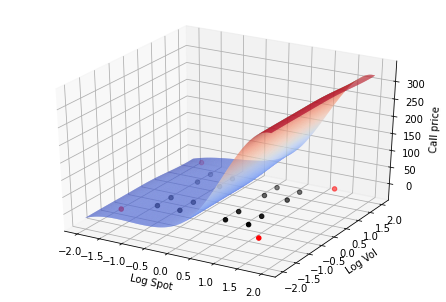

In [76]:
"""
For each log volatility , find the corresponding  1-D spline
"""
sp_vol0 = CubicSpline(logS4,call4_2d[0],bc_type = 'natural',extrapolate= True)
sp_vol1 = CubicSpline(logS4,call4_2d[1],bc_type = 'natural',extrapolate= True)
sp_vol2 = CubicSpline(logS4,call4_2d[2],bc_type = 'natural',extrapolate= True)
sp_vol3 = CubicSpline(logS4,call4_2d[3],bc_type = 'natural',extrapolate= True)

Spline_vol = np.array([])
Spline_vol = np.append(Spline_vol, sp_vol0(logS)) # for vol[0]
Spline_vol = np.append(Spline_vol, sp_vol1(logS)) # for vol[1]
Spline_vol = np.append(Spline_vol, sp_vol2(logS)) # for vol[2]
Spline_vol = np.append(Spline_vol, sp_vol3(logS)) # for vol[3]


# dimension 8X100, each row corresponding to the spline values of different volatility nodes
Spline_vol = Spline_vol.reshape(4,300)

N_Spline_logS_vol = np.array([])
# for each given log spot, fit a spline (logvol8, call price)
for i in range(0, len(logS)):
  # get the call price from the Spline_vol with vol changing from logvol8[0]....logvol8[7] for each stock price in logS
  callprice = [c for c in Spline_vol[:,i]]
  sp_logS_vol = CubicSpline(logvol4,callprice,bc_type = "natural",extrapolate= True)
  #sp_logS_vol = interp1d(logvol4,callprice, kind='cubic', fill_value="extrapolate")
  N_Spline_logS_vol = np.append(N_Spline_logS_vol, np.array(sp_logS_vol(logvol)))

N_Spline_logS_vol  = N_Spline_logS_vol.reshape(len(logS),len(logvol)) 
N_Spline_vol_logS = np.transpose(N_Spline_logS_vol)

"""
3d figure
"""
#Generate 3D graph for volatility
# Make 2-D coordinate arrays for vectorized evaluations of 2-D scalar/vector fields over 2-D grids, 
# given one-dimensional coordinate arrays x1, x2,…, xn
X, Y = np.meshgrid(logS, logvol)

# plots nodes
nodes_x,nodes_y = np.meshgrid(logS8[2:6], logvol8[2:6])
nodes_0 = np.zeros(16)
as_x,as_y = np.meshgrid([logS8[0],logS8[-1]], [logvol8[0],logvol8[-1]])

figcs = plt.figure()
ax = Axes3D(figcs)
ax.plot_surface(X, Y, N_Spline_vol_logS, rstride=1, cstride=1,cmap=cm.coolwarm,shade='interp')
ax.scatter3D(nodes_x,nodes_y,nodes_0,'o', color = 'black')
ax.scatter3D(as_x,as_y,[0,0,0,0],'o', color = 'red')

ax.set_xlabel('Log Spot')
ax.set_ylabel('Log Vol')
ax.set_zlabel('Call price')
plt.savefig('/content/drive/MyDrive/Colab Notebooks/Thesis/Graph/2D_spline_natural.eps', format='eps')  #YESSSSSSSSS
plt.show()

### (4): 3D surface: difference between the 2D natural spline and BS;

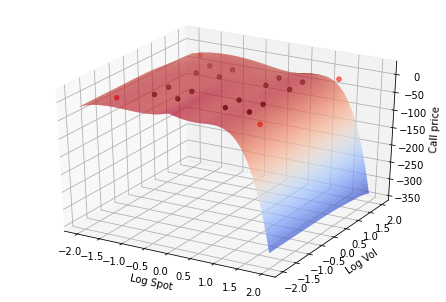

In [78]:
# differennce between the 2D natural spline and the true function

N_diff = N_Spline_vol_logS-call_2d
X, Y = np.meshgrid(logS, logvol)
# plots nodes
nodes_x,nodes_y = np.meshgrid(logS8[2:6], logvol8[2:6])
nodes_0 = np.zeros(16)
as_x,as_y = np.meshgrid([logS8[0],logS8[-1]], [logvol8[0],logvol8[-1]])

figcs = plt.figure()
ax = Axes3D(figcs)
#ax.set_xlim(-2, 2)
ax.plot_surface(X, Y, N_diff, rstride=1, cstride=1,cmap=cm.coolwarm, shade='interp')
ax.scatter3D(nodes_x,nodes_y,nodes_0,'o', color = 'black')
ax.scatter3D(as_x,as_y,[0,0,0,0],'o', color = 'red')

#ax.view_init(-140, 60)

ax.set_xlabel('Log Spot')
ax.set_ylabel('Log Vol')
ax.set_zlabel('Call price')
plt.savefig('/content/drive/MyDrive/Colab Notebooks/Thesis/Graph/Diff_naturalspline.eps', format='eps')   #YESSSSSSSSS
plt.show()

### (5): 3D surface: Difference between the 2D asymptotic spline and the BS

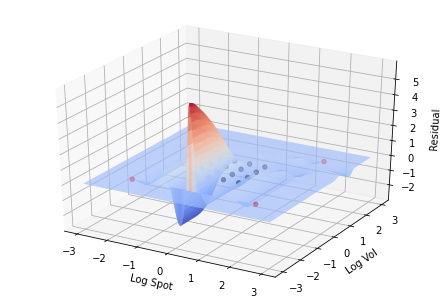

In [136]:
# differennce between the 2D asymptotic spline and the true function

diff = Spline_vol_logS_2-call_2d

"""
diff=np.array([])
for i in range(0, len(vol)):
  for j in range(0, len(S)):
    diff = np.append(diff,(Spline_vol_logS[i,j]-call_2d[i,j]))
diff = diff.reshape(len(vol),len(S))
"""
"""
3d figure
"""
X, Y = np.meshgrid(logS, logvol)
# plots nodes
nodes_x,nodes_y = np.meshgrid(logS8[2:6], logvol8[2:6])
nodes_0 = np.zeros(16)
as_x,as_y = np.meshgrid([logS8[0],logS8[-1]], [logvol8[0],logvol8[-1]])

figcs = plt.figure()
ax = Axes3D(figcs)
#diff = np.transpose(diff)
ax.plot_surface(X, Y, diff, rstride=1, cstride=1,cmap=cm.coolwarm, shade='interp')
ax.scatter3D(nodes_x,nodes_y,nodes_0,'o', color = 'black')
ax.scatter3D(as_x,as_y,[0,0,0,0],'o', color = 'red')

ax.set_xlabel('Log Spot')
ax.set_ylabel('Log Vol')
ax.set_zlabel('Residual')
plt.savefig('/content/drive/MyDrive/Colab Notebooks/Thesis/Graph/Diff_controlledspline.eps', format='eps')    #YESSSSSSSSS
plt.show()

# 3: All the NN structure 

### (1) CRL NN structure-Controlling 2D

In [143]:
class CRL(nn.Module):
    """ Customize the constrained radial layer"""
    def __init__(self,l,u,l_asym,u_asym,alpha,hidden_size):
        super(CRL,self).__init__()
        self.l, self.u, self.l_asym, self.u_asym, self.alpha = l, u ,l_asym, u_asym, alpha
        
        # center1、2， width 1、2  are the parameters 
        #c1 = torch.Tensor(hidden_size,1)
        c1 = torch.randn(hidden_size,1)
        self.c1 = nn.Parameter(c1)
        c2 = torch.randn(hidden_size,1)
        self.c2 = nn.Parameter(c2)
        w1 = torch.randn(hidden_size,1)
        self.w1 = nn.Parameter(w1)
        w2 = torch.randn(hidden_size,1)
        self.w2 = nn.Parameter(w2)
        #nn.init.uniform_(self.c1)
        #nn.init.kaiming_uniform_(self.c1, a=math.sqrt(5)) 
        
    def forward(self, x):
        c1_minus_lasm = torch.sub(self.c1,l_asym)
        uasm_minus_c1 = torch.sub(u_asym,self.c1)
       
        delta1 = torch.empty(len(c1_minus_lasm),1)

        for i in range(len(delta1)):
          delta1[i] = torch.min(c1_minus_lasm[i],uasm_minus_c1[i])
        
        #delta1 = torch.min(c1_minus_lasm,uasm_minus_c1)
        u_scaled1 = torch.div(delta1,alpha)


        c2_minus_lasm = torch.sub(self.c2,l_asym)
        uasm_minus_c2 = torch.sub(u_asym,self.c2)
        delta2 = torch.empty(len(c2_minus_lasm),1)

        for i in range(len(delta2)):
          delta2[i] = torch.min(c2_minus_lasm[i],uasm_minus_c2[i])
        #delta2 = torch.min(c2_minus_lasm,uasm_minus_c2) 
        u_scaled2 = torch.div(delta2,alpha)
        

        taoc1 = torch.div(torch.add(u*torch.exp(self.c1),l*torch.exp(-1*self.c1)),
                               torch.add(torch.exp(self.c1),torch.exp(-1*self.c1)))
  
        #print(taoc1[0])
        taoc2 = torch.div(torch.add(u*torch.exp(self.c2),l*torch.exp(-1*self.c2)),
                               torch.add(torch.exp(self.c2),torch.exp(-1*self.c2)))
        #print(taoc2)
        taow1 = torch.div(torch.add(torch.mul(u_scaled1,torch.exp(self.w1)),w_min*torch.exp(-1*self.w1)),
                          torch.add(torch.exp(self.w1),torch.exp(-1*self.w1)))
  
        taow2 = torch.div(torch.add(torch.mul(u_scaled2,torch.exp(self.w2)),w_min*torch.exp(-1*self.w2)),
                          torch.add(torch.exp(self.w2),torch.exp(-1*self.w2)))
        #print(taow2[1])
        
        Exp = torch.empty(hidden_size,len(x))
        for i in range(len(x)):
          x1_minus_taoc1 = torch.sub(x[i,0],taoc1)
          x1_minus_taoc1_square = torch.mul(x1_minus_taoc1,x1_minus_taoc1)
          taow1_square = torch.mul(taow1,taow1)
          #print(taow1)
          #print(taow1_square)
          ratio1  = torch.div(x1_minus_taoc1_square,taow1_square)

          x2_minus_taoc2 = torch.sub(x[i,1],taoc2)
          x2_minus_taoc2_square = torch.mul(x2_minus_taoc2,x2_minus_taoc2)
          taow2_square = torch.mul(taow2,taow2)
          ratio2  = torch.div(x2_minus_taoc2_square,taow2_square)  

          # return ratio2 
          sum = torch.add(ratio1,ratio2)
          Gauss = torch.exp(-0.5*sum)
          #print(Gauss.shape)
         # print(Exp.shape)
          Exp[:,i:i+1] = Gauss
          

        return Exp

class LinearLayer(nn.Module):
    """ Custom Linear layer but mimics a standard linear layer """
    def __init__(self, hidden_size):
        super(LinearLayer,self).__init__()
        self.hidden_size = hidden_size
        lamdas = torch.Tensor(1, hidden_size)
        self.lamdas = nn.Parameter(lamdas)  # nn.Parameter is a Tensor that's a module parameter.


    def forward(self, x):
        #print(len(x))
        LL = torch.empty(x.shape[1])
        for i in range(x.shape[1]):
          LL[i:i+1] = torch.mm(self.lamdas,x[:,i:i+1])
        return LL  # w times x + b


class NeuralNet(nn.Module):
    def __init__(self,l,u,l_asym,u_asym,alpha,hidden_size):
        super(NeuralNet, self).__init__()
        self.CRL = CRL(l,u,l_asym,u_asym,alpha,hidden_size)
        self.linearlayer = LinearLayer(hidden_size)
    def forward(self, x):
        out = self.CRL(x)
        out = self.linearlayer(out)
        return out

### (2) CRL NN structure-Controlling 1D

by setting a large center and width range

In [ ]:
class CRL_1D(nn.Module):
    """ Customize the constrained radial layer"""
    def __init__(self,l1,u1,l_asym1,u_asym1,l2,u2,l_asym2,u_asym2,alpha,hidden_size):
        super(CRL_1D,self).__init__()
        self.l1, self.u1, self.l_asym1, self.u_asym1, self.l2, self.u2, self.l_asym2, self.u_asym2, self.alpha = l1, u1 ,l_asym1, u_asym1, l2, u2 ,l_asym2, u_asym2, alpha
        
        # center1、2， width 1、2  are the parameters 
        #c1 = torch.Tensor(hidden_size,1)
        c1 = torch.randn(hidden_size,1)
        self.c1 = nn.Parameter(c1)
        c2 = torch.randn(hidden_size,1)
        self.c2 = nn.Parameter(c2)
        w1 = torch.randn(hidden_size,1)
        self.w1 = nn.Parameter(w1)
        w2 = torch.randn(hidden_size,1)
        self.w2 = nn.Parameter(w2)
        #nn.init.uniform_(self.c1)
        #nn.init.kaiming_uniform_(self.c1, a=math.sqrt(5)) 
        
    def forward(self, x):
        c1_minus_lasm = torch.sub(self.c1,l_asym1)
        uasm_minus_c1 = torch.sub(u_asym1,self.c1)
       
        delta1 = torch.empty(len(c1_minus_lasm),1)

        for i in range(len(delta1)):
          delta1[i] = torch.min(c1_minus_lasm[i],uasm_minus_c1[i])
        
        #delta1 = torch.min(c1_minus_lasm,uasm_minus_c1)
        u_scaled1 = torch.div(delta1,alpha)


        c2_minus_lasm = torch.sub(self.c2,l_asym2)
        uasm_minus_c2 = torch.sub(u_asym2,self.c2)
        delta2 = torch.empty(len(c2_minus_lasm),1)

        for i in range(len(delta2)):
          delta2[i] = torch.min(c2_minus_lasm[i],uasm_minus_c2[i])
        #delta2 = torch.min(c2_minus_lasm,uasm_minus_c2) 
        u_scaled2 = torch.div(delta2,alpha)
        

        taoc1 = torch.div(torch.add(u*torch.exp(self.c1),l*torch.exp(-1*self.c1)),
                               torch.add(torch.exp(self.c1),torch.exp(-1*self.c1)))
  
        #print(taoc1[0])
        taoc2 = torch.div(torch.add(u*torch.exp(self.c2),l*torch.exp(-1*self.c2)),
                               torch.add(torch.exp(self.c2),torch.exp(-1*self.c2)))
        #print(taoc2)
        taow1 = torch.div(torch.add(torch.mul(u_scaled1,torch.exp(self.w1)),w_min1*torch.exp(-1*self.w1)),
                          torch.add(torch.exp(self.w1),torch.exp(-1*self.w1)))
  
        taow2 = torch.div(torch.add(torch.mul(u_scaled2,torch.exp(self.w2)),w_min2*torch.exp(-1*self.w2)),
                          torch.add(torch.exp(self.w2),torch.exp(-1*self.w2)))
        #print(taow2[1])
        
        Exp = torch.empty(hidden_size,len(x))
        for i in range(len(x)):
          x1_minus_taoc1 = torch.sub(x[i,0],taoc1)
          x1_minus_taoc1_square = torch.mul(x1_minus_taoc1,x1_minus_taoc1)
          taow1_square = torch.mul(taow1,taow1)
          #print(taow1)
          #print(taow1_square)
          ratio1  = torch.div(x1_minus_taoc1_square,taow1_square)

          x2_minus_taoc2 = torch.sub(x[i,1],taoc2)
          x2_minus_taoc2_square = torch.mul(x2_minus_taoc2,x2_minus_taoc2)
          taow2_square = torch.mul(taow2,taow2)
          ratio2  = torch.div(x2_minus_taoc2_square,taow2_square)  

          # return ratio2 
          sum = torch.add(ratio1,ratio2)
          Gauss = torch.exp(-0.5*sum)
          #print(Gauss.shape)
         # print(Exp.shape)
          Exp[:,i:i+1] = Gauss
          

        return Exp

class LinearLayer(nn.Module):
    """ Custom Linear layer but mimics a standard linear layer """
    def __init__(self, hidden_size):
        super(LinearLayer,self).__init__()
        self.hidden_size = hidden_size
        lamdas = torch.Tensor(1, hidden_size)
        self.lamdas = nn.Parameter(lamdas)  # nn.Parameter is a Tensor that's a module parameter.


    def forward(self, x):
        #print(len(x))
        LL = torch.empty(x.shape[1])
        for i in range(x.shape[1]):
          LL[i:i+1] = torch.mm(self.lamdas,x[:,i:i+1])
        return LL  # w times x + b

class NeuralNet_1D(nn.Module):
    def __init__(self,l1,u1,l_asym1,u_asym1,l2,u2,l_asym2,u_asym2,alpha,hidden_size):
        super(NeuralNet_1D, self).__init__()
        self.CRL_1D = CRL_1D(l1,u1,l_asym1,u_asym1,l2,u2,l_asym2,u_asym2,alpha,hidden_size)
        self.linearlayer = LinearLayer(hidden_size)
    def forward(self, x):
        out = self.CRL_1D(x)
        out = self.linearlayer(out)
        return out

### (3) CRL NN structure-Controlling 4D

In [ ]:
from os import wait4
class CRL_4D(nn.Module):
    """ Customize the constrained radial layer"""
    def __init__(self,l,u,l_asym,u_asym,alpha,hidden_size):
        super(CRL_4D,self).__init__()
        self.l, self.u, self.l_asym, self.u_asym, self.alpha = l, u ,l_asym, u_asym, alpha
        
        # center1、2， width 1、2  are the parameters 
        #c1 = torch.Tensor(hidden_size,1)
        c1 = torch.randn(hidden_size,1)
        self.c1 = nn.Parameter(c1)
        c2 = torch.randn(hidden_size,1)
        self.c2 = nn.Parameter(c2)
        c3 = torch.randn(hidden_size,1)
        self.c3 = nn.Parameter(c3)
        c4 = torch.randn(hidden_size,1)
        self.c4 = nn.Parameter(c4)

        w1 = torch.randn(hidden_size,1)
        self.w1 = nn.Parameter(w1)
        w2 = torch.randn(hidden_size,1)
        self.w2 = nn.Parameter(w2)
        w3 = torch.randn(hidden_size,1)
        self.w3 = nn.Parameter(w3)
        w4 = torch.randn(hidden_size,1)
        self.w4 = nn.Parameter(w4)
        #nn.init.uniform_(self.c1)
        #nn.init.kaiming_uniform_(self.c1, a=math.sqrt(5)) 
        
    def forward(self, x):
        c1_minus_lasm = torch.sub(self.c1,l_asym)
        uasm_minus_c1 = torch.sub(u_asym,self.c1)
       
        delta1 = torch.empty(len(c1_minus_lasm),1)

        for i in range(len(delta1)):
          delta1[i] = torch.min(c1_minus_lasm[i],uasm_minus_c1[i])
        
        #delta1 = torch.min(c1_minus_lasm,uasm_minus_c1)
        u_scaled1 = torch.div(delta1,alpha)


        c2_minus_lasm = torch.sub(self.c2,l_asym)
        uasm_minus_c2 = torch.sub(u_asym,self.c2)
        delta2 = torch.empty(len(c2_minus_lasm),1)

        for i in range(len(delta2)):
          delta2[i] = torch.min(c2_minus_lasm[i],uasm_minus_c2[i])
        #delta2 = torch.min(c2_minus_lasm,uasm_minus_c2) 
        u_scaled2 = torch.div(delta2,alpha)
        
        c3_minus_lasm = torch.sub(self.c3,l_asym)
        uasm_minus_c3 = torch.sub(u_asym,self.c3)
        delta3 = torch.empty(len(c3_minus_lasm),1)

        for i in range(len(delta3)):
          delta3[i] = torch.min(c3_minus_lasm[i],uasm_minus_c3[i])
        u_scaled3 = torch.div(delta3,alpha)

        c4_minus_lasm = torch.sub(self.c4,l_asym)
        uasm_minus_c4 = torch.sub(u_asym,self.c4)
        delta4 = torch.empty(len(c4_minus_lasm),1)

        for i in range(len(delta4)):
          delta4[i] = torch.min(c4_minus_lasm[i],uasm_minus_c4[i])
        u_scaled4 = torch.div(delta4,alpha)



        taoc1 = torch.div(torch.add(u*torch.exp(self.c1),l*torch.exp(-1*self.c1)),
                               torch.add(torch.exp(self.c1),torch.exp(-1*self.c1)))
  
   
        taoc2 = torch.div(torch.add(u*torch.exp(self.c2),l*torch.exp(-1*self.c2)),
                               torch.add(torch.exp(self.c2),torch.exp(-1*self.c2)))
    
        taoc3 = torch.div(torch.add(u*torch.exp(self.c3),l*torch.exp(-1*self.c3)),
                               torch.add(torch.exp(self.c3),torch.exp(-1*self.c3)))
        
        taoc4 = torch.div(torch.add(u*torch.exp(self.c4),l*torch.exp(-1*self.c4)),
                               torch.add(torch.exp(self.c4),torch.exp(-1*self.c4))) 
             

        taow1 = torch.div(torch.add(torch.mul(u_scaled1,torch.exp(self.w1)),w_min*torch.exp(-1*self.w1)),
                          torch.add(torch.exp(self.w1),torch.exp(-1*self.w1)))
  
        taow2 = torch.div(torch.add(torch.mul(u_scaled2,torch.exp(self.w2)),w_min*torch.exp(-1*self.w2)),
                          torch.add(torch.exp(self.w2),torch.exp(-1*self.w2)))
        
        taow3 = torch.div(torch.add(torch.mul(u_scaled3,torch.exp(self.w3)),w_min*torch.exp(-1*self.w3)),
                          torch.add(torch.exp(self.w3),torch.exp(-1*self.w3)))
        
        taow4 = torch.div(torch.add(torch.mul(u_scaled4,torch.exp(self.w4)),w_min*torch.exp(-1*self.w4)),
                          torch.add(torch.exp(self.w4),torch.exp(-1*self.w4)))
        
        Exp = torch.empty(hidden_size,len(x))
        for i in range(len(x)):
          x1_minus_taoc1 = torch.sub(x[i,0],taoc1)
          x1_minus_taoc1_square = torch.mul(x1_minus_taoc1,x1_minus_taoc1)
          taow1_square = torch.mul(taow1,taow1)
          ratio1  = torch.div(x1_minus_taoc1_square,taow1_square)

          x2_minus_taoc2 = torch.sub(x[i,1],taoc2)
          x2_minus_taoc2_square = torch.mul(x2_minus_taoc2,x2_minus_taoc2)
          taow2_square = torch.mul(taow2,taow2)
          ratio2  = torch.div(x2_minus_taoc2_square,taow2_square)  

          x3_minus_taoc3 = torch.sub(x[i,2],taoc3)
          x3_minus_taoc3_square = torch.mul(x3_minus_taoc3,x3_minus_taoc3)
          taow3_square = torch.mul(taow3,taow3)
          ratio3  = torch.div(x3_minus_taoc3_square,taow3_square) 

          x4_minus_taoc4 = torch.sub(x[i,3],taoc4)
          x4_minus_taoc4_square = torch.mul(x4_minus_taoc4,x4_minus_taoc4)
          taow4_square = torch.mul(taow4,taow4)
          ratio4  = torch.div(x4_minus_taoc4_square,taow4_square) 

          # return ratio2 
          sum = torch.add(torch.add(ratio1,ratio2),torch.add(ratio3,ratio4))
          Gauss = torch.exp(-0.5*sum)
          #print(Gauss.shape)
         # print(Exp.shape)
          Exp[:,i:i+1] = Gauss
          

        return Exp


class LinearLayer(nn.Module):
    """ Custom Linear layer but mimics a standard linear layer """
    def __init__(self, hidden_size):
        super(LinearLayer,self).__init__()
        self.hidden_size = hidden_size
        lamdas = torch.Tensor(1, hidden_size)
        self.lamdas = nn.Parameter(lamdas)  # nn.Parameter is a Tensor that's a module parameter.


    def forward(self, x):
        #print(len(x))
        LL = torch.empty(x.shape[1])
        for i in range(x.shape[1]):
          LL[i:i+1] = torch.mm(self.lamdas,x[:,i:i+1])
        return LL  # w times x + b

class NeuralNet_4D(nn.Module):
    def __init__(self,l,u,l_asym,u_asym,alpha,hidden_size):
        super(NeuralNet_4D, self).__init__()
        self.CRL = CRL_4D(l,u,l_asym,u_asym,alpha,hidden_size)
        self.linearlayer = LinearLayer(hidden_size)
    def forward(self, x):
        out = self.CRL(x)
        out = self.linearlayer(out)
        return out

### (4) Standard NN with Gaussian

In [ ]:
class gaussian(nn.Module):

    def __init__(self):
        super(gaussian,self).__init__()

    def forward(self, x):
        return torch.exp(-torch.mul(x,x))

class Net_standard_Gaussian(nn.Module):

    def __init__(self):
        super(Net_standard_Gaussian, self).__init__()

        # an affine operation: y = Wx + b
        self.fc1 = nn.Linear(2,250)  
        self.fc2 = nn.Linear(250, 2)
        self.fc3 = nn.Linear(2,1,bias= False)
        self.gaussian = gaussian()

    def forward(self, x):
        x = self.fc1(x)
        x = self.gaussian(x)
        x = self.fc2(x)
        x = self.gaussian(x)
        x = self.fc3(x)
        return x

### (5) Standard NN with Sigmoid

In [ ]:
class sigmoid(nn.Module):

    def __init__(self):
        super(sigmoid,self).__init__()

    def forward(self, x):
        return torch.div(1,torch.add(1,torch.exp(-x)))

class Net_standard_sigmoid(nn.Module):

    def __init__(self):
        super(Net_standard_sigmoid, self).__init__()

        # an affine operation: y = Wx + b
        self.fc1 = nn.Linear(2,100)  
        self.fc2 = nn.Linear(100, 2)
        self.fc3 = nn.Linear(2, 1,bias= False)
        self.sigmoid = sigmoid()
        #self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.fc1(x)
        x = self.sigmoid(x)
        x = self.fc2(x)
        x = self.sigmoid(x)
        x = self.fc3(x)
        return x

# 4: Fit CRL to BS model

## 4-1: Get the Dataframe --8 nodes


### (1) Training data [-1,1]x[-1,1]


In [202]:
# Create 100x100 BS prices in the learning region -1~1
logS_train = np.linspace(-1, 1, num=100, endpoint = True)
logvol_train = np.linspace(-1, 1, num=100, endpoint = True) 
logS_train_df = pd.DataFrame(logS_train.reshape(len(logS_train),1))
logvol_train_df = pd.DataFrame(logvol_train.reshape(len(logS_train),1))

S_train =[np.exp(s)*K for s in logS_train] # x = log(S/K)  
vol_train =[np.exp(v)*vol_ref for v in logvol_train]


call_train = np.array([])
for i in range(0, len(vol_train)):
  for j in range(0, len(logS_train)):
    call_train = np.append(call_train, BS_CALL(S_train[j], K, T, r, vol_train[i])) # K = 100, T = 1, r = 0.05

call_train = call_train.reshape(len(S_train),len(vol_train))

"""
For each log volatility , find the corresponding  1-D spline
"""
sp_vol0 = CubicSpline(logS8,call8_2d[0],bc_type = ((1, Delta(S8[0], K, r, vol8[0], T)*S8[0]), (1, Delta(S8[-1], K, r, vol8[0], T)*S8[-1])),extrapolate= True)
sp_vol1 = CubicSpline(logS8,call8_2d[1],bc_type = ((1, Delta(S8[0], K, r, vol8[1], T)*S8[0]), (1, Delta(S8[-1], K, r, vol8[1], T)*S8[-1])),extrapolate= True)
sp_vol2 = CubicSpline(logS8,call8_2d[2],bc_type = ((1, Delta(S8[0], K, r, vol8[2], T)*S8[0]), (1, Delta(S8[-1], K, r, vol8[2], T)*S8[-1])),extrapolate= True)
sp_vol3 = CubicSpline(logS8,call8_2d[3],bc_type = ((1, Delta(S8[0], K, r, vol8[3], T)*S8[0]), (1, Delta(S8[-1], K, r, vol8[3], T)*S8[-1])),extrapolate= True)
sp_vol4 = CubicSpline(logS8,call8_2d[4],bc_type = ((1, Delta(S8[0], K, r, vol8[4], T)*S8[0]), (1, Delta(S8[-1], K, r, vol8[4], T)*S8[-1])),extrapolate= True)
sp_vol5 = CubicSpline(logS8,call8_2d[5],bc_type = ((1, Delta(S8[0], K, r, vol8[5], T)*S8[0]), (1, Delta(S8[-1], K, r, vol8[5], T)*S8[-1])),extrapolate= True)
sp_vol6 = CubicSpline(logS8,call8_2d[6],bc_type = ((1, Delta(S8[0], K, r, vol8[6], T)*S8[0]), (1, Delta(S8[-1], K, r, vol8[6], T)*S8[-1])),extrapolate= True)
sp_vol7 = CubicSpline(logS8,call8_2d[7],bc_type = ((1, Delta(S8[0], K, r, vol8[7], T)*S8[0]), (1, Delta(S8[-1], K, r, vol8[7], T)*S8[-1])),extrapolate= True)


Spline_vol_train = np.array([])
Spline_vol_train = np.append(Spline_vol_train, New_spline(sp_vol0, logS_train, logS8[0],logS8[-1],vol8[0])) # for vol[0]
Spline_vol_train = np.append(Spline_vol_train, New_spline(sp_vol1, logS_train, logS8[0],logS8[-1],vol8[1])) # for vol[1]
Spline_vol_train = np.append(Spline_vol_train, New_spline(sp_vol2, logS_train, logS8[0],logS8[-1],vol8[2])) # for vol[2]
Spline_vol_train = np.append(Spline_vol_train, New_spline(sp_vol3, logS_train, logS8[0],logS8[-1],vol8[3])) # for vol[3]
Spline_vol_train = np.append(Spline_vol_train, New_spline(sp_vol4, logS_train, logS8[0],logS8[-1],vol8[4])) # for vol[4]
Spline_vol_train = np.append(Spline_vol_train, New_spline(sp_vol5, logS_train, logS8[0],logS8[-1],vol8[5])) # for vol[5]
Spline_vol_train = np.append(Spline_vol_train, New_spline(sp_vol6, logS_train, logS8[0],logS8[-1],vol8[6])) # for vol[6]
Spline_vol_train = np.append(Spline_vol_train, New_spline(sp_vol7, logS_train, logS8[0],logS8[-1],vol8[7])) # for vol[7]

# dimension 8X40, each row corresponding to the spline values of different volatility nodes
Spline_vol_train = Spline_vol_train.reshape(8,len(logS_train))

# for each given log spot, fit a spline (logvol8, call price)
Spline_logS_vol_2_train = np.array([])

for i in range(0, len(logS_train)):
  # get the call price from the Spline_vol with vol changing from logvol8[0]....logvol8[7] for each stock price in logS
  callprice = [c for c in Spline_vol_train[:,i]]
  sp_logS_vol = CubicSpline(logvol8,callprice, bc_type = ((1, Vega(S_train[i], K, r, vol8[0], T)*vol8[0]), (1, Vega(S_train[i], K, r, vol8[-1], T)*vol8[-1])),extrapolate= True)
  Spline_logS_vol_2_train = np.append(Spline_logS_vol_2_train, New_spline_sigma(sp_logS_vol,logvol_train,logvol8[0],logvol8[-1],S_train[i]))

Spline_logS_vol_2_train = Spline_logS_vol_2_train.reshape(len(logS_train),len(logvol_train)) 
Spline_vol_logS_2_train = np.transpose(Spline_logS_vol_2_train)

diff_train = Spline_vol_logS_2_train-call_train

# residual function here for N = 100 is the diff function from last section
Diff_train = diff_train.reshape(len(diff_train)**2,1)
Y_train = pd.DataFrame(Diff_train)
#Y_Train = preprocessing.normalize(Y_Train_0,axis=0)

x1_train, x2_train = np.meshgrid(logS_train_df, logvol_train_df)
x1_train = x1_train.reshape(len(x1_train)**2,1)
x2_train = x2_train.reshape(len(x2_train)**2,1)

# combine the data 
X_train = np.hstack((x1_train,x2_train))
X_train = pd.DataFrame(X_train)
X_train.columns = ['logS_train', 'logvol_train']
x_train = X_train
y_train = Y_train



### (2) Testing data [-3,3]x[-3,3]

In [203]:
# Create 300x300 BS prices in the learning region -3~3
logS_test = np.linspace(-3, 3, num=300)
logvol_test= np.linspace(-3, 3, num=300) 
logS_test_df = pd.DataFrame(logS_test.reshape(len(logS_test),1))
logvol_test_df = pd.DataFrame(logvol_test.reshape(len(logS_test),1))

S_test =[np.exp(s)*K for s in logS_test] # x = log(S/K)  
vol_test =[np.exp(v)*vol_ref for v in logvol_test]


call_test = np.array([])
for i in range(0, len(vol_test)):
  for j in range(0, len(logS_test)):
    call_test = np.append(call_test, BS_CALL(S_test[j], K, T, r, vol_test[i])) # K = 100, T = 1, r = 0.05

call_test = call_test.reshape(len(S_test),len(vol_test))


"""
For each log volatility , find the corresponding  1-D spline
"""
sp_vol0 = CubicSpline(logS8,call8_2d[0],bc_type = ((1, Delta(S8[0], K, r, vol8[0], T)*S8[0]), (1, Delta(S8[-1], K, r, vol8[0], T)*S8[-1])),extrapolate= True)
sp_vol1 = CubicSpline(logS8,call8_2d[1],bc_type = ((1, Delta(S8[0], K, r, vol8[1], T)*S8[0]), (1, Delta(S8[-1], K, r, vol8[1], T)*S8[-1])),extrapolate= True)
sp_vol2 = CubicSpline(logS8,call8_2d[2],bc_type = ((1, Delta(S8[0], K, r, vol8[2], T)*S8[0]), (1, Delta(S8[-1], K, r, vol8[2], T)*S8[-1])),extrapolate= True)
sp_vol3 = CubicSpline(logS8,call8_2d[3],bc_type = ((1, Delta(S8[0], K, r, vol8[3], T)*S8[0]), (1, Delta(S8[-1], K, r, vol8[3], T)*S8[-1])),extrapolate= True)
sp_vol4 = CubicSpline(logS8,call8_2d[4],bc_type = ((1, Delta(S8[0], K, r, vol8[4], T)*S8[0]), (1, Delta(S8[-1], K, r, vol8[4], T)*S8[-1])),extrapolate= True)
sp_vol5 = CubicSpline(logS8,call8_2d[5],bc_type = ((1, Delta(S8[0], K, r, vol8[5], T)*S8[0]), (1, Delta(S8[-1], K, r, vol8[5], T)*S8[-1])),extrapolate= True)
sp_vol6 = CubicSpline(logS8,call8_2d[6],bc_type = ((1, Delta(S8[0], K, r, vol8[6], T)*S8[0]), (1, Delta(S8[-1], K, r, vol8[6], T)*S8[-1])),extrapolate= True)
sp_vol7 = CubicSpline(logS8,call8_2d[7],bc_type = ((1, Delta(S8[0], K, r, vol8[7], T)*S8[0]), (1, Delta(S8[-1], K, r, vol8[7], T)*S8[-1])),extrapolate= True)

Spline_vol_test = np.array([])
Spline_vol_test = np.append(Spline_vol_test, New_spline(sp_vol0, logS_test, logS8[0],logS8[-1],vol8[0])) # for vol[0]
Spline_vol_test = np.append(Spline_vol_test, New_spline(sp_vol1, logS_test, logS8[0],logS8[-1],vol8[1])) # for vol[1]
Spline_vol_test = np.append(Spline_vol_test, New_spline(sp_vol2, logS_test, logS8[0],logS8[-1],vol8[2])) # for vol[2]
Spline_vol_test = np.append(Spline_vol_test, New_spline(sp_vol3, logS_test, logS8[0],logS8[-1],vol8[3])) # for vol[3]
Spline_vol_test = np.append(Spline_vol_test, New_spline(sp_vol4, logS_test, logS8[0],logS8[-1],vol8[4])) # for vol[4]
Spline_vol_test = np.append(Spline_vol_test, New_spline(sp_vol5, logS_test, logS8[0],logS8[-1],vol8[5])) # for vol[5]
Spline_vol_test = np.append(Spline_vol_test, New_spline(sp_vol6, logS_test, logS8[0],logS8[-1],vol8[6])) # for vol[6]
Spline_vol_test = np.append(Spline_vol_test, New_spline(sp_vol7, logS_test, logS8[0],logS8[-1],vol8[7])) # for vol[7]

# dimension 8X40, each row corresponding to the spline values of different volatility nodes
Spline_vol_test = Spline_vol_test.reshape(8,len(logS_test))

# for each given log spot, fit a spline (logvol8, call price)
Spline_logS_vol_2_test = np.array([])

for i in range(0, len(logS_test)):
  # get the call price from the Spline_vol with vol changing from logvol8[0]....logvol8[7] for each stock price in logS
  callprice = [c for c in Spline_vol_test[:,i]]
  sp_logS_vol = CubicSpline(logvol8,callprice, bc_type = ((1, Vega(S_test[i], K, r, vol8[0], T)*vol8[0]), (1, Vega(S_test[i], K, r, vol8[-1], T)*vol8[-1])),extrapolate= True)
  Spline_logS_vol_2_test = np.append(Spline_logS_vol_2_test, New_spline_sigma(sp_logS_vol,logvol_test,logvol8[0],logvol8[-1],S_test[i]))

Spline_logS_vol_2_test = Spline_logS_vol_2_test.reshape(len(logS_test),len(logvol_test)) 
Spline_vol_logS_2_test = np.transpose(Spline_logS_vol_2_test)

diff_test = Spline_vol_logS_2_test-call_test

# residual function here for N = 100 is the diff function from last section
Diff_test = diff_test.reshape(len(diff_test)**2,1)
y_test = pd.DataFrame(Diff_test)

x1_test, x2_test = np.meshgrid(logS_test_df, logvol_test_df)
x1_test = x1_test.reshape(len(x1_test)**2,1)
x2_test = x2_test.reshape(len(x2_test)**2,1)

# combine the data 
x_test = np.hstack((x1_test,x2_test))
x_test = pd.DataFrame(x_test)
x_test.columns = ['logS_test', 'logvol_test']



#### (2-1) Plot S(x)-BS

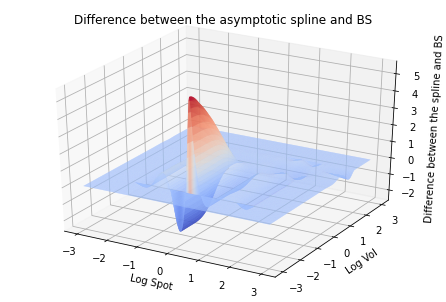

In [142]:
"""
3d figure
"""
X, Y = np.meshgrid(logS_test, logvol_test)


figcs = plt.figure()
ax = Axes3D(figcs)
ax.plot_surface(X, Y, diff_test, rstride=1, cstride=1,cmap=cm.coolwarm, shade='interp')

plt.title('Difference between the asymptotic spline and BS')
ax.set_xlabel('Log Spot')
ax.set_ylabel('Log Vol')
ax.set_zlabel('Difference between the spline and BS')
 
plt.show()

## 4-2: Train CRL, 1000 epoch

#### (2-1) Set parameters and datainput

In [204]:
# set our hyperparameters
hidden_size = 200
num_epochs = 1000
batch_size = 100 
learning_rate = 0.001

# set the constraints on centres and width of gaussian kernel
l= -1 
u= 1
l_asym= -2
u_asym= 2
alpha=3
w_min = 0.05

# prepare data
x_traintorch = torch.from_numpy(x_train.values).float()
y_traintorch = torch.from_numpy(np.array(y_train))
x_testtorch = torch.from_numpy(x_test.values).float()
y_testtorch= torch.from_numpy(np.array(y_test))
x_test_0torch = torch.from_numpy(x_test_0.values).float()
y_test_0torch= torch.from_numpy(np.array(y_test_0))

# loading data
train = torch.utils.data.TensorDataset(x_traintorch, y_traintorch)
train_loader = torch.utils.data.DataLoader(train, batch_size=batch_size, shuffle = True)
test = torch.utils.data.TensorDataset(x_testtorch, y_testtorch)
test_loader = torch.utils.data.DataLoader(test)
test_0 = torch.utils.data.TensorDataset(x_test_0torch, y_test_0torch)
test_0_loader = torch.utils.data.DataLoader(test_0)

#### (2-2) Training

In [97]:
# calling the neural network
net = NeuralNet(l,u,l_asym,u_asym,alpha,hidden_size)

# net=net.load_state_dict(torch.load(''))

# define the loss function as MSE
criterion = nn.MSELoss()
# Fix the optimisation method to be stochastic gradient descent (SGD)
optimiser = torch.optim.SGD(net.parameters(), lr=learning_rate)


In [98]:
total_step = len(train_loader)
loss_values = []

for epoch in range(num_epochs+1):

    net.train()
    train_loss = 0.0

    for i, (inputs, labels) in enumerate(train_loader, 0):
        labels = labels
        outputs = net(inputs)
        outputs = outputs.reshape(len(outputs),-1)
        loss = criterion(outputs, labels.float())

    # backward and optimise
        optimiser.zero_grad()
        loss.backward()
        optimiser.step()

    # update loss
        train_loss += loss.item()

    # print training statistics
        # = numer of training data / batch size  = number of batches
        if (i+1) % 100 == 0:
            print('Epoch [{}/{}] \t Iteration [{}/{}] \t Training Loss: {:.6f}'.format(epoch, num_epochs, i+1, total_step, train_loss / total_step))
            loss_values.append(train_loss / total_step)
            train_loss = 0.0
  
#torch.save(net.state_dict(),'/content/drive/MyDrive/Colab Notebooks/Thesis/NN/CRL_NN_1000.pt')
#torch.save(net.state_dict(),'/content/drive/MyDrive/Colab Notebooks/Thesis/NN/CRL_NN_1000_new.pt')
loss_values = pd.DataFrame(loss_values)
#loss_values.to_csv('/content/drive/MyDrive/Colab Notebooks/Thesis/NN/CRL_NN_1000_loss.csv')
#loss_values.to_csv('/content/drive/MyDrive/Colab Notebooks/Thesis/NN/CRL_NN_1000_loss_new.csv')

print('Finished Training')

Epoch [0/1000] 	 Iteration [100/100] 	 Training Loss: 6.163584
Epoch [1/1000] 	 Iteration [100/100] 	 Training Loss: 4.831337
Epoch [2/1000] 	 Iteration [100/100] 	 Training Loss: 3.997331
Epoch [3/1000] 	 Iteration [100/100] 	 Training Loss: 3.376614
Epoch [4/1000] 	 Iteration [100/100] 	 Training Loss: 2.879941
Epoch [5/1000] 	 Iteration [100/100] 	 Training Loss: 2.475297
Epoch [6/1000] 	 Iteration [100/100] 	 Training Loss: 2.144237
Epoch [7/1000] 	 Iteration [100/100] 	 Training Loss: 1.873935
Epoch [8/1000] 	 Iteration [100/100] 	 Training Loss: 1.652181
Epoch [9/1000] 	 Iteration [100/100] 	 Training Loss: 1.468597
Epoch [10/1000] 	 Iteration [100/100] 	 Training Loss: 1.315040
Epoch [11/1000] 	 Iteration [100/100] 	 Training Loss: 1.184292
Epoch [12/1000] 	 Iteration [100/100] 	 Training Loss: 1.072022
Epoch [13/1000] 	 Iteration [100/100] 	 Training Loss: 0.974806
Epoch [14/1000] 	 Iteration [100/100] 	 Training Loss: 0.887786
Epoch [15/1000] 	 Iteration [100/100] 	 Training L

##### Plot: training loss vs epoch

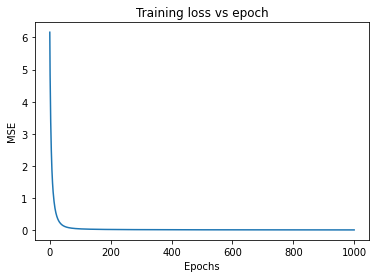

In [101]:
loss_values = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Thesis/NN/CRL_NN_1000_loss_new.csv')
loss_values.drop(columns= loss_values.columns[0], axis=1, inplace=True)
plt.plot(loss_values, label='Training')
plt.xlabel("Epochs")
plt.ylabel("MSE")
plt.title("Training loss vs epoch")
plt.savefig('/content/drive/MyDrive/Colab Notebooks/Thesis/Graph/CRL_NN_1000_Trainloss.eps', format='eps')
plt.show()

Basically, from the graph above, we can see that as epoch increases, the training loss decreases, it decreases quickly in the first 100 epoch, then the training loss decreases slowly and tends to be flat. Therefore, for the training after, we would probably try epoch = 500 instead 1000 or higher to save time.

#### (2-3) Testing

In [102]:
#net = NeuralNet(l,u,l_asym,u_asym,alpha,hidden_size)
#net.load_state_dict(torch.load('content/drive/MyDrive/Colab Notebooks/Thesis/NN/CRL_NN_1000.pt'))

from sklearn.metrics import mean_squared_error
###################
# test the model #
###################
net.eval()
MLP_pred=[]
for inputs, labels in test_loader:
    inputs = inputs
    labels = labels
    outputs = net(inputs)

    predicted= outputs.detach().numpy()
    predicted = list(predicted)
    MLP_pred.extend(predicted)

MLP_pred = pd.DataFrame(MLP_pred)
#MLP_pred.to_csv('/content/drive/MyDrive/Colab Notebooks/Thesis/NN/CRL_NN_1000_MLP_pred.csv')
#MLP_pred.to_csv('/content/drive/MyDrive/Colab Notebooks/Thesis/NN/CRL_NN_1000_MLP_pred_new.csv')
print('MSE of  test images: {}'.format(mean_squared_error(MLP_pred,y_test)))

MSE of  test images: 0.5996532601604065


##### Plot: Fit result in [-3,3]x[-3,3]


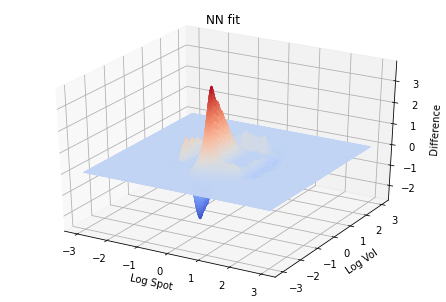

In [205]:
"""
3d figure
"""
MLP_pred = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Thesis/NN/CRL_NN_1000_MLP_pred.csv")
MLP_pred.drop(columns = MLP_pred.columns[0], axis=1, inplace=True)

X = np.array(x_test['logS_test'])
X = X.reshape(100,int(len(X)/100))
Y = np.array(x_test['logvol_test'])
Y = Y.reshape(100,int(len(Y)/100))
Z = np.array(MLP_pred)
Z = Z.reshape(100,int(len(Z)/100))

figcss = plt.figure()
ax = Axes3D(figcss)

ax.plot_surface(X, Y, Z, rstride=1, cstride=1,cmap=cm.coolwarm,shade='interp')

plt.title('NN fit')
ax.set_xlabel('Log Spot')
ax.set_ylabel('Log Vol')
ax.set_zlabel('Difference')
#plt.savefig('/content/drive/MyDrive/Colab Notebooks/Thesis/Graph/CRL_NN_1000_Testresult.eps', format='eps')
plt.show()

##### Plot: Fit diff = fit - residual in [-3,3]x[-3,3]


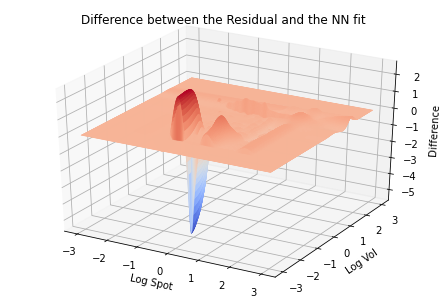

In [206]:
"""
3d figure
"""
X = np.array(x_test['logS_test'])
X = X.reshape(100,int(len(X)/100))
Y = np.array(x_test['logvol_test'])
Y = Y.reshape(100,int(len(Y)/100))
fit_dif = MLP_pred-np.array(y_test)
Z = np.array(fit_dif)
Z = Z.reshape(100,int(len(Z)/100))



figcss = plt.figure()
ax = Axes3D(figcss)
ax.plot_surface(X, Y, Z, rstride=1, cstride=1,cmap=cm.coolwarm, shade='interp')

plt.title('Difference between the Residual and the NN fit')
ax.set_xlabel('Log Spot')
ax.set_ylabel('Log Vol')
ax.set_zlabel('Difference ')
#plt.savefig('/content/drive/MyDrive/Colab Notebooks/Thesis/Graph/CRL_NN_1000_Testdiff.eps', format='eps')
plt.show()

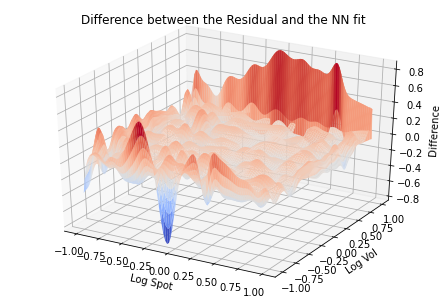

In [207]:
"""
3d figure
"""
a = np.where(logS_test >= -1)[0][0]
b = np.where(logS_test <= 1)[0][-1]

c = np.where(logvol_test >= -1)[0][0]
d = np.where(logvol_test <= 1)[0][-1]



X = np.array(x_test['logS_test'])
X = X.reshape(int(np.sqrt(len(X))),int(np.sqrt(len(X))))
X = X[a:b+1,:]
X = X[:,a:b+1]

Y = np.array(x_test['logvol_test'])
Y = Y.reshape(int(np.sqrt(len(Y))),int(np.sqrt(len(Y))))
Y = Y[c:d+1,:]
Y = Y[:,c:d+1]


fit_dif = MLP_pred-np.array(y_test)
Z = np.array(fit_dif)
Z = Z.reshape(int(np.sqrt(len(Z))),int(np.sqrt(len(Z))))
Z = Z[a:b+1,:]
Z = Z[:,c:d+1]


figcss = plt.figure()
ax = Axes3D(figcss)
ax.plot_surface(X, Y, Z, rstride=1, cstride=1,cmap=cm.coolwarm, shade='interp')
#ax.set_zlim3d(-5, 2) 

plt.title('Difference between the Residual and the NN fit')
ax.set_xlabel('Log Spot')
ax.set_ylabel('Log Vol')
ax.set_zlabel('Difference ')
#plt.savefig('/content/drive/MyDrive/Colab Notebooks/Thesis/Graph/CRL_NN_1000_Testdiff_learn.eps', format='eps')
plt.show()

# 5: Fit the Standard Neural Network to BS



### (1) Gaussian activation

In [208]:
# set our hyperparameters 
num_epochs = 1000
batch_size = 100 
learning_rate = 0.001 

# prepare data
x_traintorch = torch.from_numpy(x_train.values).float()
y_traintorch = torch.from_numpy(np.array(y_train))
x_testtorch = torch.from_numpy(x_test.values).float()
y_testtorch= torch.from_numpy(np.array(y_test))

# loading data
train = torch.utils.data.TensorDataset(x_traintorch, y_traintorch)
train_loader = torch.utils.data.DataLoader(train, batch_size=batch_size, shuffle = True)
test = torch.utils.data.TensorDataset(x_testtorch, y_testtorch)
test_loader = torch.utils.data.DataLoader(test)

In [151]:
###################
# Train the model #
###################

net_st= Net_standard_Gaussian()
criterion = nn.MSELoss()
optimiser = torch.optim.SGD(net_st.parameters(), lr=learning_rate)

total_step = len(train_loader)
loss_values_gaussian = []

for epoch in range(num_epochs+1):

    net_st.train()
    train_loss = 0.0
  
    for i, (images, labels) in enumerate(train_loader, 0):
            
    # reshape images to long vector
        #images = images.reshape(images.shape[0], 1, 28,28)
        images = images
        labels = labels
        
    # forward pass
        outputs = net_st(images)
        loss = criterion(outputs, labels.float())
    # backward and optimise
        optimiser.zero_grad()
        loss.backward()
        optimiser.step()

    # update loss
        train_loss += loss.item()

    # print training statistics
        if (i+1) % 100 == 0:
            print('Epoch [{}/{}] \t Iteration [{}/{}] \t Training Loss: {:.6f}'.format(epoch, num_epochs, i+1, total_step, train_loss / total_step))
            loss_values_gaussian.append(train_loss / total_step)
            train_loss = 0.0


print('Finished Training')

loss_values_gaussian = pd.DataFrame(loss_values_gaussian)
#loss_values_gaussian.to_csv('/content/drive/MyDrive/Colab Notebooks/Thesis/NN/Gaussian_NN_loss.csv')
#loss_values_gaussian.to_csv('/content/drive/MyDrive/Colab Notebooks/Thesis/NN/Gaussian_NN_loss_new.csv')
#torch.save(net_st.state_dict(),'/content/drive/MyDrive/Colab Notebooks/Thesis/NN/Gaussian_NN.pt')
#torch.save(net_st.state_dict(),'/content/drive/MyDrive/Colab Notebooks/Thesis/NN/Gaussian_NN_new.pt')


Epoch [0/1000] 	 Iteration [100/100] 	 Training Loss: 0.791895
Epoch [1/1000] 	 Iteration [100/100] 	 Training Loss: 0.790599
Epoch [2/1000] 	 Iteration [100/100] 	 Training Loss: 0.789981
Epoch [3/1000] 	 Iteration [100/100] 	 Training Loss: 0.789492
Epoch [4/1000] 	 Iteration [100/100] 	 Training Loss: 0.789029
Epoch [5/1000] 	 Iteration [100/100] 	 Training Loss: 0.788566
Epoch [6/1000] 	 Iteration [100/100] 	 Training Loss: 0.788090
Epoch [7/1000] 	 Iteration [100/100] 	 Training Loss: 0.787685
Epoch [8/1000] 	 Iteration [100/100] 	 Training Loss: 0.787092
Epoch [9/1000] 	 Iteration [100/100] 	 Training Loss: 0.786848
Epoch [10/1000] 	 Iteration [100/100] 	 Training Loss: 0.786441
Epoch [11/1000] 	 Iteration [100/100] 	 Training Loss: 0.786039
Epoch [12/1000] 	 Iteration [100/100] 	 Training Loss: 0.785586
Epoch [13/1000] 	 Iteration [100/100] 	 Training Loss: 0.785345
Epoch [14/1000] 	 Iteration [100/100] 	 Training Loss: 0.784947
Epoch [15/1000] 	 Iteration [100/100] 	 Training L

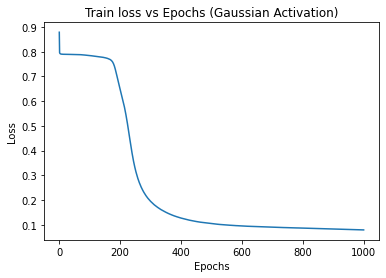

In [152]:
loss_values_gaussian = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Thesis/NN/Gaussian_NN_loss.csv")
loss_values_gaussian.drop(columns = loss_values_gaussian.columns[0], axis=1, inplace=True)

#Training loss vs epoch under Standard Neural Network with Gaussian Activation
plt.plot(loss_values_gaussian, label='Training')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Train loss vs Epochs (Gaussian Activation)")
plt.savefig('/content/drive/MyDrive/Colab Notebooks/Thesis/NN/Gaussian_NN_loss.eps', format='eps')
plt.show()

In [153]:
###################
# Relard saved neural Network #
net_st= Net_standard_Gaussian()
net_st.load_state_dict(torch.load('/content/drive/MyDrive/Colab Notebooks/Thesis/NN/Gaussian_NN.pt'))

###################
# test the model #
###################
net_st.eval()
total = 0
NN_standard_gau_pred=[]
for inputs, labels in test_loader:
    #input = inputs.reshape(-1,2)
    labels = labels
    outputs = net_st(inputs)
    #print(outputs.data)
    predicted = outputs.data
    #print(predicted)
    predicted= predicted.numpy()
    predicted=list(predicted)
    NN_standard_gau_pred.extend(predicted)
mse_stardard = mean_squared_error(NN_standard_gau_pred,y_test)

print('MSE: {} '.format(mse_stardard))

MSE: 0.666973282380712 


##### Plot: Fit result in [-3,3]x[-3,3]

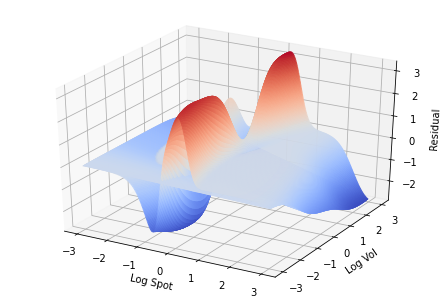

In [154]:
"""
3d figure
"""

X = np.array(x_test['logS_test'])
X = X.reshape(100,int(len(X)/100))
Y = np.array(x_test['logvol_test'])
Y = Y.reshape(100,int(len(Y)/100))
Z = np.array(NN_standard_gau_pred)
Z = Z.reshape(100,int(len(Z)/100))


figcss = plt.figure()
ax = Axes3D(figcss)
ax.plot_surface(X, Y, Z, rstride=1, cstride=1,cmap=cm.coolwarm, shade='interp')

ax.set_xlabel('Log Spot')
ax.set_ylabel('Log Vol')
ax.set_zlabel('Residual')
plt.savefig('/content/drive/MyDrive/Colab Notebooks/Thesis/Graph/Standard NN with Gaussian fit.eps', format='eps')
plt.show()

##### Plot: Fit diff = fit -residual in [-3,3]x[-3,3]

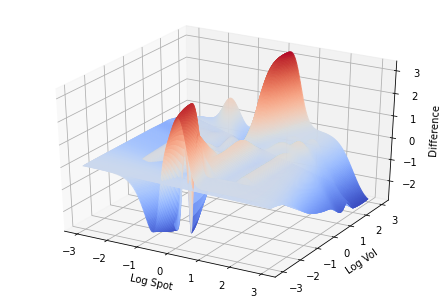

In [155]:
"""
3d figure
"""
X = np.array(x_test['logS_test'])
X = X.reshape(100,int(len(X)/100))
Y = np.array(x_test['logvol_test'])
Y = Y.reshape(100,int(len(Y)/100))
fit_dif = NN_standard_gau_pred-np.array(y_test)
Z = np.array(fit_dif)
Z = Z.reshape(100,int(len(Z)/100))

figcss = plt.figure()
ax = Axes3D(figcss)
ax.plot_surface(X, Y, Z, rstride=1, cstride=1,cmap=cm.coolwarm, shade='interp')



ax.set_xlabel('Log Spot')
ax.set_ylabel('Log Vol')
ax.set_zlabel('Difference ')
plt.savefig('/content/drive/MyDrive/Colab Notebooks/Thesis/Graph/Difference between the function and the NN fit_gaussian', format='eps')
plt.show()

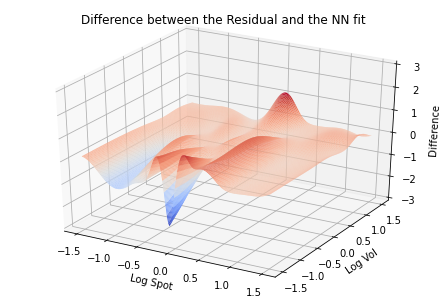

In [156]:
"""
3d figure
"""

Z = np.array(fit_dif)
Z = Z.reshape(100,int(len(Z)/100))

X = np.array(x_test['logS_test'])
X = X.reshape(int(np.sqrt(len(X))),int(np.sqrt(len(X))))
X = X[a:b+1,:]
X = X[:,a:b+1]

Y = np.array(x_test['logvol_test'])
Y = Y.reshape(int(np.sqrt(len(Y))),int(np.sqrt(len(Y))))
Y = Y[c:d+1,:]
Y = Y[:,c:d+1]


fit_dif = NN_standard_gau_pred-np.array(y_test)
Z = np.array(fit_dif)
Z = Z.reshape(int(np.sqrt(len(Z))),int(np.sqrt(len(Z))))
Z = Z[a:b+1,:]
Z = Z[:,c:d+1]


figcss = plt.figure()
ax = Axes3D(figcss)
ax.plot_surface(X, Y, Z, rstride=1, cstride=1,cmap=cm.coolwarm, shade='interp')
ax.set_zlim3d(-3, 3) 

plt.title('Difference between the Residual and the NN fit')
ax.set_xlabel('Log Spot')
ax.set_ylabel('Log Vol')
ax.set_zlabel('Difference ')
plt.savefig('/content/drive/MyDrive/Colab Notebooks/Thesis/Graph/Difference between the function and the NN fit_gaussian_learn.eps', format='eps')
plt.show()

# 6: Experiments with Heston Model

## (1) Function to calculate Heston price

The code below reference to:
https://github.com/quantpie/Heston_European_Options

In [166]:
#Class to hold the relevant functions

class Heston(object):
    
    def __init__(self,S0,K,tau,r,kappa,theta,v0,lamda,sigma,rho): #Constructor for initiating the class
        
        self.x0=math.log(S0);
        self.ln_k=math.log(K);
        self.r=r;
        self.v0=v0;
        self.kappa=kappa;
        self.theta=theta;
        self.lamda=lamda;
        self.sigma=sigma;
        self.rho=rho;
        self.tau=tau;
   
        self.a=kappa*theta;
        self.u=[0.5,-0.5];
        self.b=[kappa+lamda-rho*sigma,kappa+lamda];
        
    def reset_parameters(self,S0,K,tau,r,kappa,theta,v0,lamda,sigma,rho): # Function for resetting the constant parameters
        self.x0=math.log(S0);
        self.ln_k=math.log(K);
        self.r=r;
        self.v0=v0;
        self.kappa=kappa;
        self.theta=theta;
        self.lamda=lamda;
        self.sigma=sigma;
        self.rho=rho;
        self.tau=tau;
   
        self.a=kappa*theta;
        self.u=[0.5,-0.5];
        self.b=[kappa+lamda-rho*sigma,kappa+lamda];       
       
    
    def characteristic_func(self,phi):#Return the characteristic functions f1 and f2, each of which has a real and a complex part
        
        d=[0.0,0.0];g=[0.0,0.0];C=[0.0,0.0];D=[0.0,0.0];edt=[0.0,0.0];gedt=[0.0,0.0]; f=[0.0,0.0];

        for j in range(2):

            temp=self.b[j]-1j*self.rho*self.sigma*phi;

            d[j]=cmath.sqrt(temp**2-self.sigma**2*(2.0*self.u[j]*phi*1j-phi**2));

            g[j]=(temp+d[j])/(temp-d[j]);

            edt[j]=cmath.exp(d[j]*self.tau);
            gedt[j]=1.0-g[j]*edt[j];

            D[j]=(temp+d[j])*(1.0-edt[j])/gedt[j]/self.sigma/self.sigma;
            C[j]=self.r*phi*self.tau*1j+self.a/self.sigma/self.sigma*((temp+d[j])*self.tau-2.0*cmath.log(gedt[j]/(1.0-g[j])));
            f[j]=cmath.exp(C[j]+D[j]*self.v0+1j*phi*self.x0);     
            
        return f;    
 
    def f1(self,phi):#f1,j=0
        
        d=[0.0,0.0];g=[0.0,0.0];C=[0.0,0.0];D=[0.0,0.0];edt=[0.0,0.0];gedt=[0.0,0.0]; f=[0.0,0.0];

        j=0;

        temp=self.b[j]-1j*self.rho*self.sigma*phi;

        d[j]=cmath.sqrt(temp**2-self.sigma**2*(2.0*self.u[j]*phi*1j-phi**2));
        g[j]=(temp+d[j])/(temp-d[j]);

        edt[j]=cmath.exp(d[j]*self.tau);
        gedt[j]=1.0-g[j]*edt[j];

        D[j]=(temp+d[j])*(1.0-edt[j])/gedt[j]/self.sigma/self.sigma;
        C[j]=self.r*phi*self.tau*1j+self.a/self.sigma/self.sigma*((temp+d[j])*self.tau-2.0*cmath.log(gedt[j]/(1.0-g[j])));
        f[j]=cmath.exp(C[j]+D[j]*self.v0+1j*phi*self.x0);

        return f[0];    
    
    def f2(self,phi):# f2, j=1
        
        d=[0.0,0.0];g=[0.0,0.0];C=[0.0,0.0];D=[0.0,0.0];edt=[0.0,0.0];gedt=[0.0,0.0]; f=[0.0,0.0];

        j=1;

        temp=self.b[j]-1j*self.rho*self.sigma*phi;

        d[j]=cmath.sqrt(temp**2-self.sigma**2*(2.0*self.u[j]*phi*1j-phi**2));
        g[j]=(temp+d[j])/(temp-d[j]);

        edt[j]=cmath.exp(d[j]*self.tau);
        gedt[j]=1.0-g[j]*edt[j];

        D[j]=(temp+d[j])*(1.0-edt[j])/gedt[j]/self.sigma/self.sigma;
        C[j]=self.r*phi*self.tau*1j+self.a/self.sigma/self.sigma*((temp+d[j])*self.tau-2.0*cmath.log(gedt[j]/(1.0-g[j])));
        f[j]=cmath.exp(C[j]+D[j]*self.v0+1j*phi*self.x0);
        
        return f[1];     
      
    def P1_integrand(self,phi): #Returns the integrand in P1 formula
        temp=cmath.exp(-1j*phi*self.ln_k)*self.f1(phi)/1j/phi;
        return temp.real;

    def P2_integrand(self,phi):  #Returns the integrand in P2 formula
        temp=cmath.exp(-1j*phi*self.ln_k)*self.f2(phi)/1j/phi;
        return temp.real;
    
    def Probabilities(self,a,b,n):  #Compute the two probabilities: a and b are the integration limits, n is the number of intervals
                                    # usually the interval >0 to 100 captures the range that matters, so no need to go to b=infinity!
        pi_i=1.0/math.pi;
        P1=0.5+pi_i*trapzd(self.P1_integrand,a,b,n); #trapzd function is de
        P2=0.5+pi_i*trapzd(self.P2_integrand,a,b,n);
        P=[P1,P2];
        return P;
    
    def price(self,a,b,n):
        Ps=self.Probabilities(a,b,n);
        
        call_price=math.exp(self.x0)*Ps[0]-math.exp(self.ln_k-self.r*self.tau)*Ps[1];
        
        return call_price;
  #end class
  
        
def trapzd(func,a,b,n): #Trapzoid method for numerical integration, one can also use a function from scipy.integrate library
        
    if (n<1):
        return ;
    elif (n==1):
        return 0.5*(b-a)*(func(a)+func(b));
    else:
            
        temp=0.0;
        dx=(b-a)/n;
            
        x=np.linspace(a,b,n+1);
        y=[func(x[i]) for i in range(n+1)];
            
        temp=0.5*dx*np.sum(y[1:]+ y[:-1]);
        return temp;
        
        
#Example
hc=Heston(S0=100,K=100,tau=1.0,r=0.05,kappa=5.0,theta=0.1,v0=0.1,lamda=0.5,sigma=0.5,rho=-0.7);

price=hc.price(0.00001,100,10000);

print("The call price of European options is below:\n")
print(price)

The call price of European options is below:

14.279695297083634


## (2): Prepare the data

### Spot & variance & Spline Functions

In [167]:
K = 100; tau = 1; kappa = 5; lamda = 0.5; rho = 0; r = 0.1; sigma_ref = 0.2; vol_ref = 0.2


###################
# Initial Spot    #
###################

logS0 = np.linspace(-2, 2, num=100, endpoint = True)
logS0_3 = [-1,0,1]
logS0_7 = [-1.5,-1.25,-1,0,1,1.25,1.5]
S0=[np.exp(s)*K for s in logS0]  # scale the spot price by K, ////// log spot = log(S/K)  
S0_3 = [np.exp(s)*K for s in logS0_3]
S0_7 = [np.exp(s)*K for s in logS0_7]

###################
# Initial Variance#
###################
## log(sgrt(v)/sig_ref) ##

logVar0 = np.linspace(-2, 2, num=100, endpoint = True)   
logVar0_3 = [-1,0,1]
logVar0_7 = [-1.5,-1.25,-1,0,1,1.25,1.5]
Var0 = [(np.exp(v)* sigma_ref)**2 for v in logVar0]
Var0_3 = [(np.exp(v)* sigma_ref)**2 for v in logVar0_3]
Var0_7 = [(np.exp(v)* sigma_ref)**2 for v in logVar0_7]

###################
# theta           #
###################
## log(sgrt(THETA)/sig_ref) ##
log_theta = np.linspace(-2, 2, num=100, endpoint = True)  
log_theta_3 = [-1,0,1]
log_theta_7 = [-1.5,-1.25,-1,0,1,1.25,1.5]
theta = [(np.exp(v)* sigma_ref)**2 for v in log_theta]
theta_3 = [(np.exp(v)* sigma_ref)**2 for v in log_theta_3]
theta_7 = [(np.exp(v)* sigma_ref)**2 for v in log_theta_7]

###################
# sigma           #
###################
log_sigma = np.linspace(-2, 2, num=100, endpoint = True)  
log_sigma_3 = [-1,0,1]
log_sigma_7 = [-1.5,-1.25,-1,0,1,1.25,1.5]
sigma = [np.exp(v) for v in log_sigma]
sigma_3 = [np.exp(v) for v in log_sigma_3]
sigma_7 = [np.exp(v) for v in log_sigma_7]

###################
# Training region  #
###################
# Create 100x100 Heston prices in the learning region -1~1
logS0_train = np.linspace(-1, 1, num=100, endpoint = True)
logVar0_train = np.linspace(-1, 1, num=100, endpoint = True) 
logS0_train_df = pd.DataFrame(logS0_train.reshape(len(logS0_train),1))
logVar0_train_df = pd.DataFrame(logVar0_train.reshape(len(logVar0_train),1))

S0_train =[np.exp(s)*K for s in logS0_train] # x = log(S/K)  
Var0_train =[(np.exp(v)*sigma_ref)**2 for v in logVar0_train] #log(sgrt(v)/sig_ref) 

###################
# Testing region  #
###################
# Create 100x100 Heston prices in the measure region -3~3
logS0_test = logS0
logVar0_test = logVar0
logS0_test_df = pd.DataFrame(logS0_test.reshape(len(logS0_test),1))
logVar0_test_df = pd.DataFrame(logVar0_test.reshape(len(logVar0_test),1))

S0_test =[np.exp(s)*K for s in logS0_test] # x = log(S/K)  
Var0_test =[(np.exp(v)*sigma_ref)**2 for v in logVar0_test]


In [168]:
def HNew_spline(splinefunc,logS,h_left,h_right, var): 
  new_spline = []
  for i in logS:
      if i <= h_left:
        hc = Heston(S0=np.exp(i)*K,K=K,tau=tau,r=r,kappa=kappa,theta=theta,v0=var,lamda=lamda,sigma=sigma,rho=rho)
        C = hc.price(0.00001,100,10000)
      if h_left < i < h_right:
        C = splinefunc(i)
      if i >= h_right:
        hc = Heston(S0=np.exp(i)*K,K=K,tau=tau,r=r,kappa=kappa,theta=theta,v0=var,lamda=lamda,sigma=sigma,rho=rho)
        C = hc.price(0.00001,100,10000)
      new_spline.append(C)
  new_spline = np.array(new_spline)
  return new_spline


def HNew_spline_var(splinefunc,logVar,h_left,h_right,S):
  new_spline = []
  for i in logVar:
      if i <= h_left:
        hc = Heston(S0=S,K=K,tau=tau,r=r,kappa=kappa,theta=theta,v0=(np.exp(i)* vol_ref)**2,lamda=lamda,sigma=sigma,rho=rho)
        C = hc.price(0.00001,100,10000)
      if h_left < i < h_right:
        C = splinefunc(i)
      if i >= h_right:
        hc = Heston(S0=S,K=K,tau=tau,r=r,kappa=kappa,theta=theta,v0=(np.exp(i)* vol_ref)**2,lamda=lamda,sigma=sigma,rho=rho)
        C = hc.price(0.00001,100,10000)
      new_spline.append(C)
  new_spline = np.array(new_spline)
  return new_spline

### Derivatives

In [ ]:
pip install py_vollib
from sympy.interactive.session import V

K = 100; tau = 1; kappa = 5; lamda = 0.5; rho = 0; r = 0.1; sigma_ref = 0.2; T=1; theta= 0.04; sigma = 0.4


###################
# dC/dS0         # 
###################
#use the delta in BS model, substitute the implied vol worked out from Heston

# BS
from py_vollib.black_scholes import black_scholes as bs
from py_vollib.black_scholes.greeks.analytical import vega
import matplotlib.pyplot as plt

#work out vega of BS
def d1(S, K, r, sigma, T):
    return (np.log(S/K) + (r+sigma*sigma/2)*T)/(sigma*np.sqrt(T))

def d2(S, K, r, sigma, T):
    return d1(S, K, r, sigma, T) - sigma*np.sqrt(T)

def Delta(S, K, r, sigma, T):
  return si.norm.cdf(d1(S, K, r, sigma, T))

#calculate the implied volatility of a European option in python by using the Newton-Raphon Method.
def implied_vol(S0, K, T, r, market_price, flag='c', tol=0.00001):
    """Compute the implied volatility of a European Option
        S0: initial stock price
        K:  strike price
        T:  maturity
        r:  risk-free rate
        market_price: market observed price
        tol: user choosen tolerance
    """
    max_iter =5 #max number of iterations
    vol_old = 0.5 #initial guess
    for k in range(max_iter):
        bs_price = bs(flag, S0, K, T, r, vol_old)
        Cprime =  vega(flag, S0, K, T, r, vol_old)*100
       #print(Cprime)
        C = bs_price - market_price
        vol_new = vol_old - C/Cprime
        bs_new = bs(flag, S0, K, T, r, vol_new)
        if (abs(vol_old - vol_new) < tol or abs(bs_new - market_price) < tol):
            break
        vol_old = vol_new
    implied_vol = vol_old
    return implied_vol

def dC_dS0(S0,v0):
  hc1 = Heston(S0=S0,K=K,tau=tau,r=r,kappa=kappa,theta=theta,v0=v0,lamda=lamda,sigma=sigma,rho=rho)
  heston_price = hc1.price(0.00001,100,10000)
  #print(heston_price)
  imp_vol = implied_vol(S0, K, T, r, heston_price, flag='c', tol=0.00001)
  #print(imp_vol)
  delta = Delta(S0, K, r, imp_vol, T)
  return delta


###################
# d_C/d_sqrtv0      # 
###################
#use finite difference

def dC_dsqrtv0(S0,v0):
  V1 = v0
  #print(V1)
  V2 = v0+0.01
  #print(V2)
  HC1 = Heston(S0=S0,K=K,tau=tau,r=r,kappa=kappa,theta=theta,v0=V1,lamda=lamda,sigma=sigma,rho=rho)
  C1 = HC1.price(0.00001,100,10000)
  #print(C1)
  HC2 = Heston(S0=S0,K=K,tau=tau,r=r,kappa=kappa,theta=theta,v0=V2,lamda=lamda,sigma=sigma,rho=rho)
  C2 = HC2.price(0.00001,100,10000)
  #print(C2)
  diff_ratio = (C2-C1)/(np.sqrt(V2)-np.sqrt(V1))
  return diff_ratio


### Heston call price

In [ ]:
#2
#Calculate the exact call price for different stock prices and variance
theta = theta_3[1]; sigma = sigma_3[0] #4

Hcall_1 = np.array([])
for i in range(0, len(Var0)):
  for j in range(0, len(S0)):
    hc = Heston(S0=S0[j],K=K,tau=tau,r=r,kappa=kappa,theta=theta,v0=Var0[i],lamda=lamda,sigma=sigma,rho=rho)
    price = hc.price(0.00001,100,10000)
    Hcall_1  = np.append(Hcall_1 ,price)  
Hcall_1 = Hcall_1.reshape(len(S0), len(Var0))
Hcall_1 = pd.DataFrame(Hcall_1)
Hcall_1.to_csv('/content/drive/MyDrive/Colab Notebooks/Thesis/Hcall_1.csv') #1

In [170]:
#3
Hcall7_1 = np.array([])
for i in range(0, len(Var0_7)):
  for j in range(0, len(S0_7)):
    hc = Heston(S0=S0_7[j],K=K,tau=tau,r=r,kappa=kappa,theta=theta,v0=Var0_7[i],lamda=lamda,sigma=sigma,rho=rho)
    price = hc.price(0.00001,100,10000)
    Hcall7_1 = np.append(Hcall7_1,price) 
Hcall7_1 = Hcall7_1.reshape(len(S0_7), len(Var0_7))

#3
Hcall3_1 = np.array([])
for i in range(0, len(Var0_3)):
  for j in range(0, len(S0_3)):
    hc = Heston(S0=S0_3[j],K=K,tau=tau,r=r,kappa=kappa,theta=theta,v0=Var0_3[i],lamda=lamda,sigma=sigma,rho=rho)
    price = hc.price(0.00001,100,10000)
    Hcall3_1 = np.append(Hcall3_1,price) 
Hcall3_1 = Hcall3_1.reshape(len(S0_3), len(Var0_3))

### Asymptotics control in 2D

In [ ]:
#4
"""
use the BS derivative substitute dC/ds0, and use finite difference subtitute dC/dv0
"""
##

sp_var0 = CubicSpline(logS0_7,Hcall7_1[0],bc_type = ((1, Delta(S0_7[0], K, r, np.sqrt(Var0_7[0]), T)*S0_7[0]), (1, Delta(S0_7[-1], K, r, np.sqrt(Var0_7[0]), T)*S0_7[-1])),extrapolate= True)
sp_var1 = CubicSpline(logS0_7,Hcall7_1[1],bc_type = ((1, Delta(S0_7[0], K, r, np.sqrt(Var0_7[1]), T)*S0_7[0]), (1, Delta(S0_7[-1], K, r, np.sqrt(Var0_7[1]), T)*S0_7[-1])),extrapolate= True)
sp_var2 = CubicSpline(logS0_7,Hcall7_1[2],bc_type = ((1, Delta(S0_7[0], K, r, np.sqrt(Var0_7[2]), T)*S0_7[0]), (1, Delta(S0_7[-1], K, r, np.sqrt(Var0_7[2]), T)*S0_7[-1])),extrapolate= True)
sp_var3 = CubicSpline(logS0_7,Hcall7_1[3],bc_type = ((1, Delta(S0_7[0], K, r, np.sqrt(Var0_7[3]), T)*S0_7[0]), (1, Delta(S0_7[-1], K, r, np.sqrt(Var0_7[3]), T)*S0_7[-1])),extrapolate= True)
sp_var4 = CubicSpline(logS0_7,Hcall7_1[4],bc_type = ((1, Delta(S0_7[0], K, r, np.sqrt(Var0_7[4]), T)*S0_7[0]), (1, Delta(S0_7[-1], K, r, np.sqrt(Var0_7[4]), T)*S0_7[-1])),extrapolate= True)
sp_var5 = CubicSpline(logS0_7,Hcall7_1[5],bc_type = ((1, Delta(S0_7[0], K, r, np.sqrt(Var0_7[5]), T)*S0_7[0]), (1, Delta(S0_7[-1], K, r, np.sqrt(Var0_7[5]), T)*S0_7[-1])),extrapolate= True)
sp_var6 = CubicSpline(logS0_7,Hcall7_1[6],bc_type = ((1, Delta(S0_7[0], K, r, np.sqrt(Var0_7[6]), T)*S0_7[0]), (1, Delta(S0_7[-1], K, r, np.sqrt(Var0_7[6]), T)*S0_7[-1])),extrapolate= True)

Spline_var = np.array([])
Spline_var = np.append(Spline_var, HNew_spline(sp_var0, logS0,logS0_7[0],logS0_7[-1],Var0_7[0])) # for var[0]
Spline_var = np.append(Spline_var, HNew_spline(sp_var1, logS0,logS0_7[0],logS0_7[-1],Var0_7[1])) # for var[1]
Spline_var = np.append(Spline_var, HNew_spline(sp_var2, logS0,logS0_7[0],logS0_7[-1],Var0_7[2])) # for var[2]
Spline_var = np.append(Spline_var, HNew_spline(sp_var3, logS0,logS0_7[0],logS0_7[-1],Var0_7[3])) # for var[3]
Spline_var = np.append(Spline_var, HNew_spline(sp_var4, logS0,logS0_7[0],logS0_7[-1],Var0_7[4])) # for var[4]
Spline_var = np.append(Spline_var, HNew_spline(sp_var5, logS0,logS0_7[0],logS0_7[-1],Var0_7[5])) # for var[5]
Spline_var = np.append(Spline_var, HNew_spline(sp_var6, logS0,logS0_7[0],logS0_7[-1],Var0_7[6])) # for var[6]


# dimension 8X100, each row corresponding to the spline values of different volatility nodes
Spline_var = Spline_var.reshape(7,len(logS0))

# for each given log spot, fit a spline (logvol8, call price)
Spline_logS_var_2 = np.array([])

for i in range(0, len(logS0)):
  # get the call price from the Spline_vol with vol changing from logvol8[0]....logvol8[7] for each stock price in logS
  callprice = [c for c in Spline_var[:,i]]
  sp_logS_var = CubicSpline(logVar0_7,callprice,bc_type = ((1,dC_dsqrtv0(S0[i],Var0_7[0])*np.sqrt(Var0_7[0])), (1,dC_dsqrtv0(S0[i],Var0_7[-1])*np.sqrt(Var0_7[-1]))),extrapolate= True)
  Spline_logS_var_2 = np.append(Spline_logS_var_2, HNew_spline_var(sp_logS_var,logVar0,logVar0_7[0],logVar0_7[-1],S0[i]))

Spline_logS_var_2 = Spline_logS_var_2.reshape(len(logS0),len(logVar0)) 
Spline_var_logS_2 = np.transpose(Spline_logS_var_2)

"""
3d figure
"""
#Generate 3D graph 
X, Y = np.meshgrid(logS0, logVar0)
as_x,as_y = np.meshgrid([logVar0_7[0],logVar0_7[-1]], [logVar0_7[0],logVar0_7[-1]])
figcs = plt.figure()
ax = Axes3D(figcs)
ax.plot_surface(X, Y, Spline_var_logS_2, rstride=1, cstride=1,cmap=cm.coolwarm, shade='interp')

plt.title('Heston Call Option Price with 2-D asymptotic control')
ax.set_xlabel('Log Spot')
ax.set_ylabel('Log Var')
ax.set_zlabel('Call price')

plt.savefig('/content/drive/MyDrive/Colab Notebooks/Thesis/Graph/H_2D_controlprice_4.eps', format='eps') #4
plt.show()

### Difference between the spline and the Heston price



In [209]:
Hcall_1 = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Thesis/Hcall_4.csv') #4
Hcall_1.drop(columns=Hcall_1.columns[0], axis=1, inplace=True)
Hdiff_1 = Spline_var_logS_2-Hcall_1
Hdiff_1.to_csv('/content/drive/MyDrive/Colab Notebooks/Thesis/Hdiff_4.csv') #4


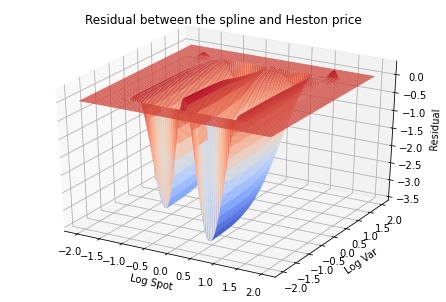

In [171]:
#7
# differennce between the 2D asymptotic spline and the true function

Hdiff_1 = Spline_var_logS_2-Hcall10_1
Hdiff_1 = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Thesis/Hdiff_4.csv') #4



Hdiff_1.drop(columns=Hdiff_1.columns[0], axis=1, inplace=True)

X, Y = np.meshgrid(logS0, logVar0)
as_x,as_y = np.meshgrid([logVar0_7[0],logVar0_7[-1]], [logVar0_7[0],logVar0_7[-1]])

figcs = plt.figure()
ax = Axes3D(figcs)
ax.plot_surface(X, Y, Hdiff_1, rstride=1, cstride=1,cmap=cm.coolwarm, shade='interp')

plt.title('Residual between the spline and Heston price')
ax.set_xlabel('Log Spot')
ax.set_ylabel('Log Var')
ax.set_zlabel('Residual')


#plt.savefig('/content/drive/MyDrive/Colab Notebooks/Thesis/Graph/H_2D_residual_4.eps', format='eps') #4

plt.show()

## (3) Fit CRL NN to Hestion model



##### 1 Learning region & Test region

In [ ]:
#8
Hcall_train_1 = np.array([])
for i in range(0, len(Var0_train)):
  for j in range(0, len(S0_train)):
    hc = Heston(S0=S0_train[j],K=K,tau=tau,r=r,kappa=kappa,theta=theta,v0=Var0_train[i],lamda=lamda,sigma=sigma,rho=rho)
    price = hc.price(0.00001,100,10000)
    Hcall_train_1  = np.append(Hcall_train_1,price)  

Hcall_train_1 = Hcall_train_1.reshape(len(S0_train),len(Var0_train))
Hcall_train_1 = pd.DataFrame(Hcall_train_1)

Hcall_train_1.to_csv('/content/drive/MyDrive/Colab Notebooks/Thesis/Hcall_train_4.csv') #4


In [172]:
#9

Hcall_train_1 = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Thesis/Hcall_train_4.csv') #4
Hcall_train_1.drop(columns=Hcall_train_1.columns[0], axis=1, inplace=True) 
Hcall_train_1 = np.array(Hcall_train_1)


Hcall_test_1 = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Thesis/Hcall_4.csv') #4
Hcall_test_1.drop(columns=Hcall_test_1.columns[0], axis=1, inplace=True)
Hcall_test_1  = np.array(Hcall_test_1)

In [ ]:
#10
"""
For each log var , find the corresponding  1-D spline
"""
sp_var0 = CubicSpline(logS0_7,Hcall7_1[0],bc_type = ((1, Delta(S0_7[0], K, r, np.sqrt(Var0_7[0]), T)*S0_7[0]), (1, Delta(S0_7[-1], K, r, np.sqrt(Var0_7[0]), T)*S0_7[-1])),extrapolate= True)
sp_var1 = CubicSpline(logS0_7,Hcall7_1[1],bc_type = ((1, Delta(S0_7[0], K, r, np.sqrt(Var0_7[1]), T)*S0_7[0]), (1, Delta(S0_7[-1], K, r, np.sqrt(Var0_7[1]), T)*S0_7[-1])),extrapolate= True)
sp_var2 = CubicSpline(logS0_7,Hcall7_1[2],bc_type = ((1, Delta(S0_7[0], K, r, np.sqrt(Var0_7[2]), T)*S0_7[0]), (1, Delta(S0_7[-1], K, r, np.sqrt(Var0_7[2]), T)*S0_7[-1])),extrapolate= True)
sp_var3 = CubicSpline(logS0_7,Hcall7_1[3],bc_type = ((1, Delta(S0_7[0], K, r, np.sqrt(Var0_7[3]), T)*S0_7[0]), (1, Delta(S0_7[-1], K, r, np.sqrt(Var0_7[3]), T)*S0_7[-1])),extrapolate= True)
sp_var4 = CubicSpline(logS0_7,Hcall7_1[4],bc_type = ((1, Delta(S0_7[0], K, r, np.sqrt(Var0_7[4]), T)*S0_7[0]), (1, Delta(S0_7[-1], K, r, np.sqrt(Var0_7[4]), T)*S0_7[-1])),extrapolate= True)
sp_var5 = CubicSpline(logS0_7,Hcall7_1[5],bc_type = ((1, Delta(S0_7[0], K, r, np.sqrt(Var0_7[5]), T)*S0_7[0]), (1, Delta(S0_7[-1], K, r, np.sqrt(Var0_7[5]), T)*S0_7[-1])),extrapolate= True)
sp_var6 = CubicSpline(logS0_7,Hcall7_1[6],bc_type = ((1, Delta(S0_7[0], K, r, np.sqrt(Var0_7[6]), T)*S0_7[0]), (1, Delta(S0_7[-1], K, r, np.sqrt(Var0_7[6]), T)*S0_7[-1])),extrapolate= True)

Spline_var = np.array([])
Spline_var = np.append(Spline_var, HNew_spline(sp_var0, logS0_train,logS0_7[0],logS0_7[-1],Var0_7[0])) # for var[0]
Spline_var = np.append(Spline_var, HNew_spline(sp_var1, logS0_train,logS0_7[0],logS0_7[-1],Var0_7[1])) # for var[1]
Spline_var = np.append(Spline_var, HNew_spline(sp_var2, logS0_train,logS0_7[0],logS0_7[-1],Var0_7[2])) # for var[2]
Spline_var = np.append(Spline_var, HNew_spline(sp_var3, logS0_train,logS0_7[0],logS0_7[-1],Var0_7[3])) # for var[3]
Spline_var = np.append(Spline_var, HNew_spline(sp_var4, logS0_train,logS0_7[0],logS0_7[-1],Var0_7[4])) # for var[4]
Spline_var = np.append(Spline_var, HNew_spline(sp_var5, logS0_train,logS0_7[0],logS0_7[-1],Var0_7[5])) # for var[5]
Spline_var = np.append(Spline_var, HNew_spline(sp_var6, logS0_train,logS0_7[0],logS0_7[-1],Var0_7[6])) # for var[6]


# dimension 8X100, each row corresponding to the spline values of different volatility nodes
Spline_var = Spline_var.reshape(7,len(logS0_train))

# for each given log spot, fit a spline (logvol8, call price)
Spline_logS_var_2 = np.array([])

for i in range(0, len(logS0)):
  # get the call price from the Spline_vol with vol changing from logvol8[0]....logvol8[7] for each stock price in logS
  callprice = [c for c in Spline_var[:,i]]
  sp_logS_var = CubicSpline(logVar0_7,callprice,bc_type = ((1,dC_dsqrtv0(S0_train[i],Var0_7[0])*np.sqrt(Var0_7[0])), (1,dC_dsqrtv0(S0_train[i],Var0_7[-1])*np.sqrt(Var0_7[-1]))),extrapolate= True)
  Spline_logS_var_2 = np.append(Spline_logS_var_2, HNew_spline_var(sp_logS_var,logVar0_train,logVar0_7[0],logVar0_7[-1],S0_train[i]))

Spline_logS_var_2 = Spline_logS_var_2.reshape(len(logS0_train),len(logVar0_train)) 
Spline_var_logS_2 = np.transpose(Spline_logS_var_2)

Hdiff_train_1 = Spline_var_logS_2 - Hcall_train_1
Hdiff_train_1 = pd.DataFrame(Hdiff_train_1)

Hdiff_train_1.to_csv('/content/drive/MyDrive/Colab Notebooks/Thesis/Hdiff_train_4.csv') #4



In [174]:
#11
# residual function here for N = 100 is the diff function from last section
Hdiff_train_1 = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Thesis/Hdiff_train_4.csv') #4
Hdiff_train_1.drop(columns=Hdiff_train_1.columns[0], axis=1, inplace=True)
Hdiff_train_1 = np.array(Hdiff_train_1)
Hdiff_train_1 = Hdiff_train_1.flatten()
Hdiff_train_1 = Hdiff_train_1.reshape(len(Hdiff_train_1),1)
Y_train = pd.DataFrame(Hdiff_train_1)

x1_train, x2_train = np.meshgrid(logS0_train_df, logVar0_train_df)
x1_train = x1_train.flatten()
x1_train = x1_train.reshape(len(x1_train),1)
x2_train = x2_train.flatten()
x2_train = x2_train.reshape(len(x2_train),1)

# combine the data 
X_train = np.hstack((x1_train,x2_train))
X_train = pd.DataFrame(X_train)
X_train.columns = ['logS0_train', 'logVar0_train']
x_train = X_train
y_train = Y_train

Hdiff_test_1 = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Thesis/Hdiff_4.csv') #4
Hdiff_test_1.drop(columns=Hdiff_test_1.columns[0], axis=1, inplace=True)
Hdiff_test_1 = np.array(Hdiff_test_1)
Hdiff_test_1 = Hdiff_test_1.flatten()
Hdiff_test_1 = Hdiff_test_1.reshape(len(Hdiff_test_1),1)

y_test = pd.DataFrame(Hdiff_test_1)
x1_test, x2_test = np.meshgrid(logS0_test_df, logVar0_test_df)
x1_test = x1_test.flatten()
x1_test = x1_test.reshape(len(x1_test),1)
x2_test = x2_test.flatten()
x2_test = x2_test.reshape(len(x2_train),1)

# combine the data 
x_test = np.hstack((x1_test,x2_test))
x_test = pd.DataFrame(x_test)
x_test.columns = ['logS0_test', 'logVar0_test']


##### 2 Train CRL NN- choose different NN structure

In [181]:
#12
###################
# set our hyperparameters   #
###################
hidden_size = 250
num_epochs = 300
batch_size = 100 
learning_rate = 0.0005

# mentioned in paper
l= -1
u= 1
l_asym= -2
u_asym= 2
alpha=3
w_min = 0.05

In [182]:
#13
# prepare data
x_traintorch = torch.from_numpy(x_train.values).float()
y_traintorch = torch.from_numpy(np.array(y_train))
x_testtorch = torch.from_numpy(x_test.values).float()
y_testtorch= torch.from_numpy(np.array(y_test))

# loading data
train = torch.utils.data.TensorDataset(x_traintorch, y_traintorch)
train_loader = torch.utils.data.DataLoader(train, batch_size=batch_size)
test = torch.utils.data.TensorDataset(x_testtorch, y_testtorch)
test_loader = torch.utils.data.DataLoader(test)

In [183]:
#14
# calling the neural network#

HNet1 = NeuralNet(l,u,l_asym,u_asym,alpha,hidden_size) # control 2D
#HNet1 = NeuralNet_1D(l1,u1,l_asym1,u_asym1,l2,u2,l_asym2,u_asym2,alpha,hidden_size) #control 1D 
#HNet1 = Net_standard_Gaussian()
#HNet1 = Net_standard_sigmoid()


# net=net.load_state_dict(torch.load(''))

criterion = nn.MSELoss()
#optimizer = torch.optim.Adam(HNet1.parameters(), lr=learning_rate)
optimiser = torch.optim.SGD(HNet1.parameters(), lr=learning_rate)


total_step = len(train_loader)
loss_values = []

for epoch in range(num_epochs+1):

    HNet1.train()
    train_loss = 0.0

    for i, (inputs, labels) in enumerate(train_loader, 0):
        labels = labels
        outputs = HNet1(inputs)
        outputs = outputs.reshape(len(outputs),-1)
        loss = criterion(outputs, labels.float())

    # backward and optimise
        optimiser.zero_grad()
        loss.backward()
        optimiser.step()

    # update loss
        train_loss += loss.item()
        if (i+1) % 100 == 0:
            print('Epoch [{}/{}] \t Iteration [{}/{}] \t Training Loss: {:.6f}'.format(epoch, num_epochs, i+1, total_step, train_loss / total_step))
            loss_values.append(train_loss / total_step)
            train_loss = 0.0
  

# 保存网络中的参数, 速度快，占空间少

torch.save(HNet1.state_dict(),'/content/drive/MyDrive/Colab Notebooks/Thesis/NN/HNet4.pt') #4
#torch.save(HNet1.state_dict(),'/content/drive/MyDrive/Colab Notebooks/Thesis/NN/HNet4_1D.pt') #4
#torch.save(HNet1.state_dict(),'/content/drive/MyDrive/Colab Notebooks/Thesis/NN/HNet4_0D_gaussian.pt') #4
#torch.save(HNet1.state_dict(),'/content/drive/MyDrive/Colab Notebooks/Thesis/NN/HNet4_0D_sigmoid.pt') #4


loss_values_df = pd.DataFrame(loss_values)
loss_values_df.to_csv("/content/drive/MyDrive/Colab Notebooks/Thesis/Trainloss_H4.csv") #4
#loss_values_df.to_csv("/content/drive/MyDrive/Colab Notebooks/Thesis/Trainloss_1D_H4.csv") #4
#loss_values_df.to_csv("/content/drive/MyDrive/Colab Notebooks/Thesis/Trainloss_0D_H4.csv") #4
#loss_values_df.to_csv("/content/drive/MyDrive/Colab Notebooks/Thesis/Trainloss_0D_H4_sigmoid.csv") #4

print('Finished Training')

Epoch [0/300] 	 Iteration [100/100] 	 Training Loss: 22.230588
Epoch [1/300] 	 Iteration [100/100] 	 Training Loss: 7.770137
Epoch [2/300] 	 Iteration [100/100] 	 Training Loss: 4.445809
Epoch [3/300] 	 Iteration [100/100] 	 Training Loss: 3.198649
Epoch [4/300] 	 Iteration [100/100] 	 Training Loss: 2.428773
Epoch [5/300] 	 Iteration [100/100] 	 Training Loss: 1.756592
Epoch [6/300] 	 Iteration [100/100] 	 Training Loss: 1.412673
Epoch [7/300] 	 Iteration [100/100] 	 Training Loss: 1.190687
Epoch [8/300] 	 Iteration [100/100] 	 Training Loss: 1.026889
Epoch [9/300] 	 Iteration [100/100] 	 Training Loss: 0.901652
Epoch [10/300] 	 Iteration [100/100] 	 Training Loss: 0.803120
Epoch [11/300] 	 Iteration [100/100] 	 Training Loss: 0.723417
Epoch [12/300] 	 Iteration [100/100] 	 Training Loss: 0.657424
Epoch [13/300] 	 Iteration [100/100] 	 Training Loss: 0.601689
Epoch [14/300] 	 Iteration [100/100] 	 Training Loss: 0.553852
Epoch [15/300] 	 Iteration [100/100] 	 Training Loss: 0.512143
E

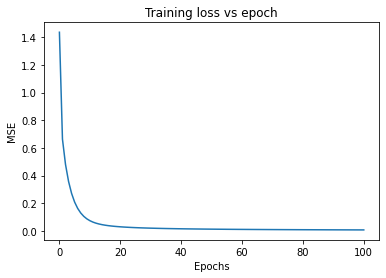

In [ ]:
#15

loss_values = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Thesis/Trainloss_H4.csv") #4
#loss_values = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Thesis/Trainloss_1D_H4.csv") #4
#loss_values = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Thesis/Trainloss_0D_H4.csv") #4
#loss_values = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Thesis/Trainloss_0D_H4_sigmoid.csv") #4


loss_values.drop(columns=loss_values.columns[0], axis=1, inplace=True)
plt.plot(loss_values, label='Training')
plt.xlabel("Epochs")
plt.ylabel("MSE")
plt.title("Training loss vs epoch")

plt.savefig('/content/drive/MyDrive/Colab Notebooks/Thesis/Graph/H_2D_trainloss_4.eps', format='eps') #4
#plt.savefig('/content/drive/MyDrive/Colab Notebooks/Thesis/Graph/H_1D_trainloss_4.eps', format='eps') #4
#plt.savefig('/content/drive/MyDrive/Colab Notebooks/Thesis/Graph/H_0D_trainloss_4.eps', format='eps') #4
#plt.savefig('/content/drive/MyDrive/Colab Notebooks/Thesis/Graph/H_0D_trainloss_4_sigmoid.eps', format='eps') #4
plt.show()

#### 3 Test--- choose different NN structure

In [184]:
#16
###################
# test the model #
###################

HNet1= NeuralNet(l,u,l_asym,u_asym,alpha,hidden_size)
#HNet1 = NeuralNet_1D(l1,u1,l_asym1,u_asym1,l2,u2,l_asym2,u_asym2,alpha,hidden_size)
#HNet1 = Net_standard_Gaussian()
#HNet1 = Net_standard_sigmoid()


HNet1.load_state_dict(torch.load('/content/drive/MyDrive/Colab Notebooks/Thesis/NN/HNet4.pt')) #4
#HNet1.load_state_dict(torch.load('/content/drive/MyDrive/Colab Notebooks/Thesis/NN/HNet4_1D.pt')) #4
#HNet1.load_state_dict(torch.load('/content/drive/MyDrive/Colab Notebooks/Thesis/NN/HNet4_0D_gaussian.pt')) #4
#HNet1.load_state_dict(torch.load('/content/drive/MyDrive/Colab Notebooks/Thesis/NN/HNet4_0D_sigmoid.pt')) #4


HNet1.eval()
HNN_pred_1=[]
for inputs, labels in test_loader:
    inputs = inputs
    labels = labels
    outputs = HNet1(inputs)

    predicted= outputs.detach().numpy()
    predicted = list(predicted)
    HNN_pred_1.extend(predicted)

HNN_pred_1_df = pd.DataFrame(HNN_pred_1)
HNN_pred_1_df.to_csv("/content/drive/MyDrive/Colab Notebooks/Thesis/HNN_pred_4.csv") #4
#HNN_pred_1_df.to_csv("/content/drive/MyDrive/Colab Notebooks/Thesis/HNN_pred_1D_4.csv") #4
#HNN_pred_1_df.to_csv("/content/drive/MyDrive/Colab Notebooks/Thesis/HNN_pred_0D_4.csv") #4
#HNN_pred_1_df.to_csv("/content/drive/MyDrive/Colab Notebooks/Thesis/HNN_pred_0D_4_sigmoid.csv") #4



print('MSE of  test images: {}'.format(mean_squared_error(HNN_pred_1,y_test)))


MSE of  test images: 0.19788462718503608


###### Plot: Fit result

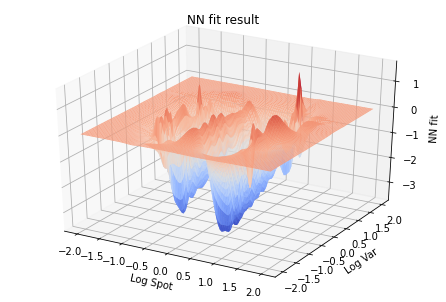

In [185]:
#17
"""
3d figure
"""

X = np.array(x_test['logS0_test'])
X = X.reshape(100,int(len(X)/100))
Y = np.array(x_test['logVar0_test'])
Y = Y.reshape(100,int(len(Y)/100))
Z = np.array(HNN_pred_1)
Z = Z.reshape(100,int(len(Z)/100))


figcss = plt.figure()
ax = Axes3D(figcss)
ax.plot_surface(X, Y, Z, rstride=1, cstride=1,cmap=cm.coolwarm, shade='interp')


plt.title('NN fit result')
ax.set_xlabel('Log Spot')
ax.set_ylabel('Log Var')
ax.set_zlabel('NN fit')


plt.savefig('/content/drive/MyDrive/Colab Notebooks/Thesis/Graph/H_2D_fitresult_4.eps', format='eps') #4
#plt.savefig('/content/drive/MyDrive/Colab Notebooks/Thesis/Graph/H_1D_fitresult_4.eps', format='eps')
#plt.savefig('/content/drive/MyDrive/Colab Notebooks/Thesis/Graph/H_0D_fitresult_4.eps', format='eps')
#plt.savefig('/content/drive/MyDrive/Colab Notebooks/Thesis/Graph/H_0D_fitresult_4_sigmoid.eps', format='eps')
plt.show()

###### Plot: Fit difference

In [186]:
#18
HNN_pred_1 = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Thesis/HNN_pred_4.csv") #4
#HNN_pred_1 = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Thesis/HNN_pred_1D_4.csv") #4
#HNN_pred_1 = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Thesis/HNN_pred_0D_4.csv") #4
#HNN_pred_1 = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Thesis/HNN_pred_0D_4_sigmoid.csv") #4



HNN_pred_1.drop(columns=HNN_pred_1.columns[0], axis=1, inplace=True)
#MLP_pred_1 = np.array(MLP_pred_1)

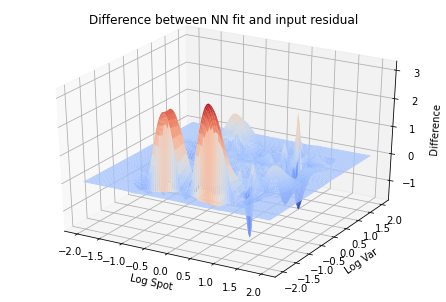

In [187]:
#19
"""
3d figure
"""
X = np.array(x_test['logS0_test'])
X = X.reshape(100,int(len(X)/100))
Y = np.array(x_test['logVar0_test'])
Y = Y.reshape(100,int(len(Y)/100))
#fit_dif = HNN_pred_1.subtract(y_test)
Z = np.array(HNN_pred_1)-np.array(y_test)
Z = Z.reshape(100,int(len(Z)/100))

figcss = plt.figure()
ax = Axes3D(figcss)
ax.plot_surface(X, Y, Z, rstride=1, cstride=1,cmap=cm.coolwarm, shade='interp')


plt.title('Difference between NN fit and input residual')
ax.set_xlabel('Log Spot')
ax.set_ylabel('Log Var')
ax.set_zlabel('Difference')


plt.savefig('/content/drive/MyDrive/Colab Notebooks/Thesis/Graph/H_2D_fitdiff_4.eps', format='eps') #4
#plt.savefig('/content/drive/MyDrive/Colab Notebooks/Thesis/Graph/H_1D_fitdiff_4.eps', format='eps')
#plt.savefig('/content/drive/MyDrive/Colab Notebooks/Thesis/Graph/H_0D_fitdiff_4.eps', format='eps')
#plt.savefig('/content/drive/MyDrive/Colab Notebooks/Thesis/Graph/H_0D_fitdiff_4_sigmoid.eps', format='eps')
plt.show()

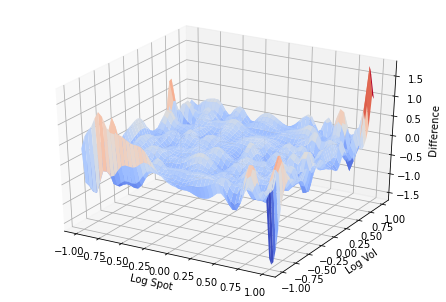

In [188]:
"""
3d figure
"""
a = np.where(logS0_test >= -1)[0][0]
b = np.where(logS0_test <= 1)[0][-1]

c = np.where(logVar0_test >= -1)[0][0]
d = np.where(logVar0_test <= 1)[0][-1]



X = np.array(x_test['logS0_test'])
X = X.reshape(int(np.sqrt(len(X))),int(np.sqrt(len(X))))
X = X[a:b+1,:]
X = X[:,a:b+1]

Y = np.array(x_test['logVar0_test'])
Y = Y.reshape(int(np.sqrt(len(Y))),int(np.sqrt(len(Y))))
Y = Y[c:d+1,:]
Y = Y[:,c:d+1]

Z =  np.array(HNN_pred_1)-np.array(y_test)
Z = Z.reshape(int(np.sqrt(len(Z))),int(np.sqrt(len(Z))))
Z = Z[a:b+1,:]
Z = Z[:,c:d+1]


figcss = plt.figure()
ax = Axes3D(figcss)
ax.plot_surface(X, Y, Z, rstride=1, cstride=1,cmap=cm.coolwarm, shade='interp')


ax.set_xlabel('Log Spot')
ax.set_ylabel('Log Vol')
ax.set_zlabel('Difference ')
plt.savefig('/content/drive/MyDrive/Colab Notebooks/Thesis/Graph/H_2D_fitdiff_4_learn.eps', format='eps')
#plt.savefig('/content/drive/MyDrive/Colab Notebooks/Thesis/Graph/H_1D_fitdiff_4_learn.eps', format='eps')
#plt.savefig('/content/drive/MyDrive/Colab Notebooks/Thesis/Graph/H_0D_fitdiff_4_learn.eps', format='eps')
#plt.savefig('/content/drive/MyDrive/Colab Notebooks/Thesis/Graph/H_0D_fitdiff_4_learn_sigmoid.eps', format='eps')

plt.show()

###### Errors: 

Every time change the neural network mode

In [ ]:
from sklearn.metrics import mean_squared_error
lS1 = np.where(logS0_test >= -1)[0][0]
lS2= np.where(logS0_test <= 1)[0][-1]

lV1 = np.where(logVar0_test >= -1)[0][0]
lV2 = np.where(logVar0_test <= 1)[0][-1]

aS1 = np.where(logS0_test >= -1.5)[0][0]
aS2= np.where(logS0_test <= 1.5)[0][-1]

aV1 = np.where(logVar0_test >= -1.5)[0][0]
aV2 = np.where(logVar0_test <= 1.5)[0][-1]

mS1 = np.where(logS0_test >= -2)[0][0]
mS2= np.where(logS0_test <= 2)[0][-1]

mV1 = np.where(logVar0_test >= -2)[0][0]
mV2 = np.where(logVar0_test <= 2)[0][-1]


#Learning region error 
ytest = np.array(y_test).reshape(int(np.sqrt(len(y_test))),int(np.sqrt(len(y_test))))
ytest_l = ytest[lS1:lS2+1,:]
ytest_l = ytest_l[:,lV1:lV2+1]
Hpred = np.array(HNN_pred_1).reshape(int(np.sqrt(len(HNN_pred_1))),int(np.sqrt(len(HNN_pred_1))))
Hpred_l = Hpred[lS1:lS2+1,:]
Hpred_l = Hpred_l[:,lV1:lV2+1]
learning_region_error = mean_squared_error(ytest_l, Hpred_l)

print("Learning region error of 2D controlled model:{}".format(learning_region_error))
#print("Learning region error of 1D controlled model:{}".format(learning_region_error))
#print("Learning region error of model without control:{}".format(learning_region_error))
#print("Learning region error of model without control_sigmoid:{}".format(learning_region_error))

#Asymptotic region error 
ytest_a1 = ytest[aS1:lS1+1,:][:,aV1:aV2+1]
ytest_a2 = ytest[lS1:lS2+1,:][:,aV1:lV1+1]
ytest_a3 = ytest[lS1:lS2+1,:][:,lV2:aV2+1]
ytest_a4 = ytest[lS2:aS2+1,:][:,aV1:aV2+1]
Hpred_a1 = Hpred[aS1:lS1+1,:][:,aV1:aV2+1]
Hpred_a2 = Hpred[lS1:lS2+1,:][:,aV1:lV1+1]
Hpred_a3 = Hpred[lS1:lS2+1,:][:,lV2:aV2+1]
Hpred_a4 = Hpred[lS2:aS2+1,:][:,aV1:aV2+1]
ytest_a = np.hstack((ytest_a1.flatten(),ytest_a2.flatten(),ytest_a3.flatten(),ytest_a4.flatten()))
Hpred_a = np.hstack((Hpred_a1.flatten(),Hpred_a2.flatten(),Hpred_a3.flatten(),Hpred_a4.flatten()))
Asymptotic_region_error = mean_squared_error(ytest_a, Hpred_a)

print("Asymptotic region error of 2D controlled model:{}".format(Asymptotic_region_error))
#print("Asymptotic region error of 1D controlled model:{}".format(Asymptotic_region_error))
#print("Asymptotic region error of model without control:{}".format(Asymptotic_region_error))
#print("Asymptotic region error of model without control_sigmoid:{}".format(Asymptotic_region_error))


#Measurement region error 
ytest_m1 = ytest[mS1:aS1+1,:][:,mV1:mV2+1]
ytest_m2 = ytest[aS1:aS2+1,:][:,mV1:aV1+1]
ytest_m3 = ytest[aS1:aS2+1,:][:,aV2:mV2+1]
ytest_m4 = ytest[aS2:mS2+1,:][:,mV1:mV2+1]

Hpred_m1 = Hpred[mS1:aS1+1,:][:,mV1:mV2+1]
Hpred_m2 = Hpred[aS1:aS2+1,:][:,mV1:aV1+1]
Hpred_m3 = Hpred[aS1:aS2+1,:][:,aV2:mV2+1]
Hpred_m4 = Hpred[aS2:mS2+1,:][:,mV1:mV2+1]

ytest_m = np.hstack((ytest_m1.flatten(),ytest_m2.flatten(),ytest_m3.flatten(),ytest_m4.flatten()))
Hpred_m = np.hstack((Hpred_m1.flatten(),Hpred_m2.flatten(),Hpred_m3.flatten(),Hpred_m4.flatten()))
Measure_region_error = mean_squared_error(ytest_m, Hpred_m)

print("Measurement region error of 2D controlled model:{}".format(Measure_region_error))
#print("Measurement region error of 1D controlled model:{}".format(Measure_region_error))
#print("Measurement region error of model without control:{}".format(Measure_region_error))
#print("Measurement region error of model without control_sigmoid:{}".format(Measure_region_error))



# Validation error
vali_error = mean_squared_error(ytest, Hpred)

print("Validation error of 2D controlled model:{}".format(vali_error))
#print("Validation error of 1D controlled model:{}".format(vali_error))
#print("Validation error of model without control:{}".format(vali_error))
#print("Validation error of model without control_sigmoid:{}".format(vali_error))
